In [3]:
import os
from collections import defaultdict
import awkward as ak
import numba
import numpy as np
import h5py
import vector
vector.register_numba()
vector.register_awkward()

from sklearn.metrics import roc_curve, auc

import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
hep.style.use(hep.style.ROOT)
matplotlib.rcParams.update({'font.size': 16})

# Predictions on fully-matched dataset of model trained on inclusive dataset

In [4]:
filename_train = "/eos/user/m/mmarcheg/ttHbb/training_datasets/spanet_v2/h5/tthbb_ttbar_with_ctag_one_hot_encoding_full_Run2_train_8608106.h5" 
filename_test = "/eos/user/m/mmarcheg/ttHbb/training_datasets/spanet_v2/h5/tthbb_ttbar_with_ctag_one_hot_encoding_full_Run2_test_2152028.h5"
filename_pred = "/eos/user/m/mmarcheg/ttHbb/predictions/spanet_v2/multiclassifier_btag_LMH/spanet_output/version_1/predictions_multiclassifier_full_Run2_test_2152028.h5"
plots_folder = "multiclassifier_full_Run2_ttbb_reweighed"
os.makedirs(plots_folder, exist_ok=True)
df_train = h5py.File(filename_train,'r')
df_test = h5py.File(filename_test,'r')
df_pred = h5py.File(filename_pred,'r')

In [5]:
df_pred["TARGETS"]["h"].keys()

<KeysViewHDF5 ['assignment_probability', 'b1', 'b2', 'detection_probability', 'marginal_probability']>

## Compute the jet assignment efficiency
We extract the predicted and true indices for the individual quarks.
Jets are correctly assigned when the predicted jet index is equal to the true index. We can compute the efficiency as the ratio of the correctly assigned jets over the total number of jets.

In [6]:
idx_b1_pred = df_pred["TARGETS"]["h"]["b1"][()]
idx_b2_pred = df_pred["TARGETS"]["h"]["b2"][()]
idx_b1_pred

array([4, 1, 0, ..., 3, 4, 3])

In [7]:
idx_b1_true = df_test["TARGETS"]["h"]["b1"][()]
idx_b2_true = df_test["TARGETS"]["h"]["b2"][()]
idx_b1_true

array([-1,  1, -1, ...,  3, -1, -1])

In [8]:
idx_h_pred = ak.concatenate((ak.unflatten(idx_b1_pred, ak.ones_like(idx_b1_pred)), ak.unflatten(idx_b2_pred, ak.ones_like(idx_b2_pred))), axis=1)
idx_h_true = ak.concatenate((ak.unflatten(idx_b1_true, ak.ones_like(idx_b1_true)), ak.unflatten(idx_b2_true, ak.ones_like(idx_b2_true))), axis=1)
idx_h_pred

<Array [[4, 4], [1, 3], ... [4, 4], [3, 3]] type='2152028 * var * int64'>

In [9]:
idx_h_true

<Array [[-1, -1], [1, -1, ... -1], [-1, -1]] type='2152028 * var * int64'>

In [10]:
is_correct_higgs = ak.sum(idx_h_pred == idx_h_true, axis=1) == 2
is_correct_higgs

<Array [False, False, False, ... False, False] type='2152028 * bool'>

In [11]:
n_tot = len(is_correct_higgs)
n_tot

2152028

In [12]:
n_correct = ak.sum(is_correct_higgs)
n_correct

217276

In [13]:
eff_h = n_correct / n_tot
eff_h

0.1009633703650696

In [14]:
idx_q1_pred = df_pred["TARGETS"]["t1"]["q1"][()]
idx_q2_pred = df_pred["TARGETS"]["t1"]["q2"][()]
idx_b_pred = df_pred["TARGETS"]["t1"]["b"][()]
idx_q1_true = df_test["TARGETS"]["t1"]["q1"][()]
idx_q2_true = df_test["TARGETS"]["t1"]["q2"][()]
idx_b_true = df_test["TARGETS"]["t1"]["b"][()]
idx_b_pred

array([3, 4, 1, ..., 4, 0, 4])

In [15]:
idx_thad_pred = ak.concatenate(
     (ak.unflatten(idx_q1_pred, ak.ones_like(idx_q1_pred)),
     ak.unflatten(idx_q2_pred, ak.ones_like(idx_q2_pred)),
     ak.unflatten(idx_b_pred, ak.ones_like(idx_b_pred))),
     axis=1)
idx_thad_true = ak.concatenate(
     (ak.unflatten(idx_q1_true, ak.ones_like(idx_q1_true)),
     ak.unflatten(idx_q2_true, ak.ones_like(idx_q2_true)),
     ak.unflatten(idx_b_true, ak.ones_like(idx_b_true))),
     axis=1)
idx_thad_pred

<Array [[0, 2, 3], [5, 6, ... 3, 0], [0, 2, 4]] type='2152028 * var * int64'>

In [16]:
is_correct_thad = ak.sum(idx_thad_pred == idx_thad_true, axis=1) == 3
is_correct_thad

<Array [True, True, True, ... True, False] type='2152028 * bool'>

In [17]:
n_correct = ak.sum(is_correct_thad)
n_tot = len(is_correct_thad)
eff_thad = n_correct / n_tot
eff_thad

0.2669082372534186

In [18]:
idx_b_pred = df_pred["TARGETS"]["t2"]["b"][()]
idx_b_true = df_test["TARGETS"]["t2"]["b"][()]
idx_tlep_pred = ak.unflatten(idx_b_pred, ak.ones_like(idx_b_pred))
idx_tlep_true = ak.unflatten(idx_b_true, ak.ones_like(idx_b_pred))
idx_tlep_pred

<Array [[1], [2], [3], ... [1], [2], [1]] type='2152028 * var * int64'>

In [19]:
is_correct_tlep = ak.sum(idx_tlep_pred == idx_tlep_true, axis=1) == 1
is_correct_tlep

<Array [True, True, True, ... True, False] type='2152028 * bool'>

In [20]:
n_correct = ak.sum(is_correct_tlep)
n_tot = len(is_correct_tlep)
eff_tlep = n_correct / n_tot
eff_tlep

0.6917010373470978

## Resulting Higgs and top reconstruction efficiencies
The Higgs and top efficiencies are defined as the number of events with all the jets correctly assigned over the total number of events:

$\epsilon = \frac{N_{assigned}}{N_{tot}}$

In [21]:
eff_h, eff_thad, eff_tlep

(0.1009633703650696, 0.2669082372534186, 0.6917010373470978)

In [22]:
idx_h_true

<Array [[-1, -1], [1, -1, ... -1], [-1, -1]] type='2152028 * var * int64'>

## Classification performance
We plot the classification score for the ttHbb signal and ttbar background.

In [23]:
label = "signal"
df_pred[f"CLASSIFICATIONS/EVENT/{label}"][()]

array([[1.06625065e-11, 9.59080905e-02, 2.07090061e-02, 5.57784401e-02,
        8.27604413e-01],
       [8.15915321e-11, 8.80899370e-01, 8.99863169e-02, 1.60908867e-02,
        1.30234296e-02],
       [1.95178613e-11, 2.12058574e-01, 1.11526623e-01, 1.59834534e-01,
        5.16580224e-01],
       ...,
       [4.74619372e-11, 9.01536703e-01, 5.54316640e-02, 1.14876656e-02,
        3.15439627e-02],
       [3.56208552e-12, 5.13448268e-02, 7.24763498e-02, 9.20157284e-02,
        7.84163058e-01],
       [2.09055592e-10, 2.36943662e-01, 4.55959402e-02, 8.44817460e-02,
        6.32978678e-01]], dtype=float32)

In [24]:
class_true = np.array(df_test[f"CLASSIFICATIONS/EVENT/signal"][()])
class_true

array([4, 1, 4, ..., 1, 4, 4])

In [25]:
df_pred[f"CLASSIFICATIONS/EVENT/signal"][()]

array([[1.06625065e-11, 9.59080905e-02, 2.07090061e-02, 5.57784401e-02,
        8.27604413e-01],
       [8.15915321e-11, 8.80899370e-01, 8.99863169e-02, 1.60908867e-02,
        1.30234296e-02],
       [1.95178613e-11, 2.12058574e-01, 1.11526623e-01, 1.59834534e-01,
        5.16580224e-01],
       ...,
       [4.74619372e-11, 9.01536703e-01, 5.54316640e-02, 1.14876656e-02,
        3.15439627e-02],
       [3.56208552e-12, 5.13448268e-02, 7.24763498e-02, 9.20157284e-02,
        7.84163058e-01],
       [2.09055592e-10, 2.36943662e-01, 4.55959402e-02, 8.44817460e-02,
        6.32978678e-01]], dtype=float32)

In [26]:
class_prediction = np.argmax(df_pred[f"CLASSIFICATIONS/EVENT/signal"][()], axis=1)
class_prediction

array([4, 1, 4, ..., 1, 4, 4])

In [27]:
labels = ["tthbb", "ttbb", "ttcc", "ttlf"]
for index, label in zip([1,2,3,4], labels):
    mask = class_true == index
    eff = sum(class_true[mask] == class_prediction[mask]) / len(class_true[mask])
    print(label, round(eff,3))

tthbb 0.888
ttbb 0.114
ttcc 0.007
ttlf 0.765


In [29]:
!pip install seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 4.6 MB/s eta 0:00:00ta 0:00:01


              precision    recall  f1-score   support

     ttH(bb)       0.60      0.89      0.72    752114
        tt+B       0.44      0.11      0.18    166514
        tt+C       0.48      0.01      0.01    258000
       tt+LF       0.75      0.76      0.76    975400

    accuracy                           0.67   2152028
   macro avg       0.57      0.44      0.42   2152028
weighted avg       0.64      0.67      0.61   2152028



<Figure size 1000x800 with 0 Axes>

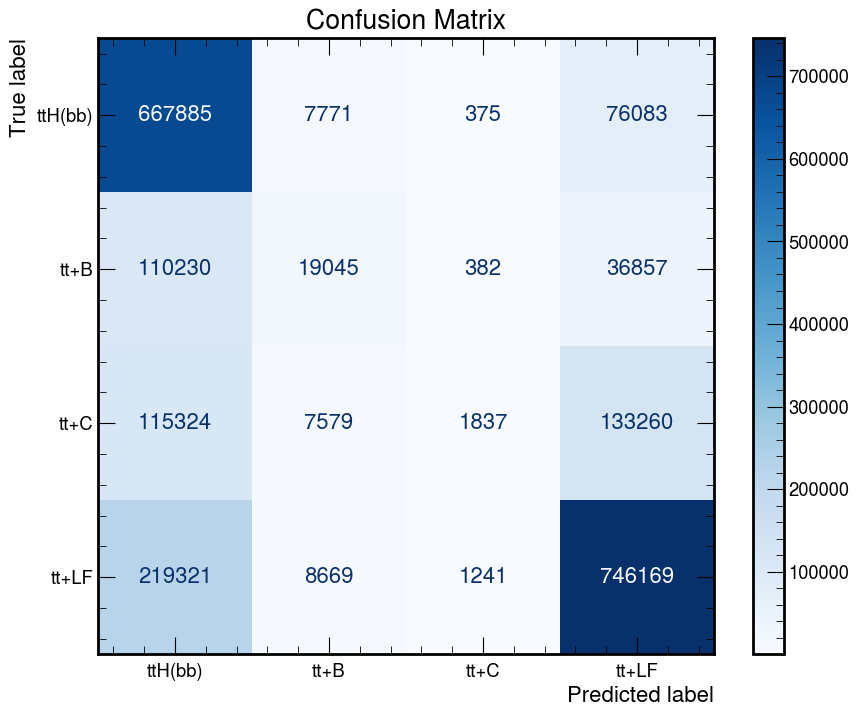

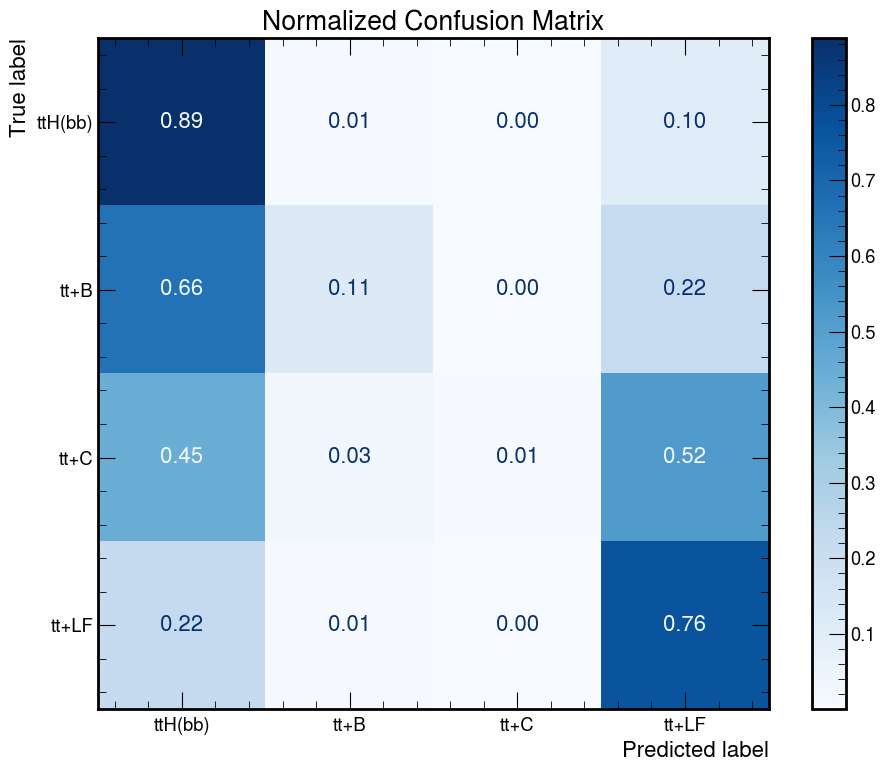

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming class_true and class_prediction are already defined as in your code
# class_true = np.array(df_test[f"CLASSIFICATIONS/EVENT/signal"][()])
# class_prediction = np.argmax(df_pred[f"CLASSIFICATIONS/EVENT/signal"][()], axis=1)

# Define the class labels with strings
class_mapping = {
    1: 'ttH(bb)',
    2: 'tt+B',
    3: 'tt+C',
    4: 'tt+LF'
}

# Get the unique class labels as integers
numeric_labels = np.unique(np.concatenate((class_true, class_prediction)))

# Create string labels for the plot
labels = [class_mapping.get(label, f'Unknown {label}') for label in numeric_labels]

# Calculate the confusion matrix using numeric labels
cm = confusion_matrix(class_true, class_prediction, labels=numeric_labels)

# Create a figure and axes for the plot
plt.figure(figsize=(10, 8))

# Calculate row-normalized confusion matrix (normalize by true labels)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Replace NaN with 0 (in case there are rows with all zeros)
cm_normalized = np.nan_to_num(cm_normalized)

# Create two subplots: one for counts and one for normalized values
#fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

# Plot the raw counts
#sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
#            xticklabels=labels, yticklabels=labels, ax=ax1)
#ax1.set_title('Confusion Matrix (Counts)')
#ax1.set_xlabel('Predicted Label')
#ax1.set_ylabel('True Label')

# Plot the normalized values (by row)
#sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', 
#            xticklabels=labels, yticklabels=labels, ax=ax2)
#ax2.set_title('Confusion Matrix (Row Normalized)')
#ax2.set_xlabel('Predicted Label')
#ax2.set_ylabel('True Label')

# Alternatively, you can use sklearn's ConfusionMatrixDisplay with normalization
# Fig for non-normalized
fig3, ax3 = plt.subplots(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Blues', values_format='d', ax=ax3)
ax3.set_title('Confusion Matrix')

# Fig for normalized
fig4, ax4 = plt.subplots(figsize=(10, 8))
disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_normalized, display_labels=labels)
disp_norm.plot(cmap='Blues', values_format='.2f', ax=ax4)
ax4.set_title('Normalized Confusion Matrix')

# Show all plots
plt.tight_layout()
#plt.show()

# Print classification metrics
from sklearn.metrics import classification_report

# Create target names for the classification report
target_names = [class_mapping.get(label, f'Unknown {label}') for label in numeric_labels]

print(classification_report(class_true, class_prediction, 
                           labels=numeric_labels, 
                           target_names=target_names))

In [34]:
df_pred[f"CLASSIFICATIONS/EVENT/signal"][()][:,1]

array([0.09590809, 0.88089937, 0.21205857, ..., 0.9015367 , 0.05134483,
       0.23694366], dtype=float32)

In [48]:
df_test[f"CLASSIFICATIONS/EVENT/signal"][()]

array([4, 1, 4, ..., 1, 4, 4])

In [49]:
labels = ["tthbb", "ttbb", "ttcc", "ttlf"]
true_labels = {}
pred_labels = {}
weights = df_test["WEIGHTS/weight"][:]
for index, label in zip([1,2,3,4], labels):
    true_labels[label] = np.array(df_test[f"CLASSIFICATIONS/EVENT/signal"][()]) == index
    pred_labels[label] = np.array(df_pred[f"CLASSIFICATIONS/EVENT/signal"][()][:,index])
true_labels

{'tthbb': array([False,  True, False, ...,  True, False, False]),
 'ttbb': array([False, False, False, ..., False, False, False]),
 'ttcc': array([False, False, False, ..., False, False, False]),
 'ttlf': array([ True, False,  True, ..., False,  True,  True])}

In [50]:
weights.shape

(2152028,)

In [51]:
pred_labels

{'tthbb': array([0.09590809, 0.88089937, 0.21205857, ..., 0.9015367 , 0.05134483,
        0.23694366], dtype=float32),
 'ttbb': array([0.02070901, 0.08998632, 0.11152662, ..., 0.05543166, 0.07247635,
        0.04559594], dtype=float32),
 'ttcc': array([0.05577844, 0.01609089, 0.15983453, ..., 0.01148767, 0.09201573,
        0.08448175], dtype=float32),
 'ttlf': array([0.8276044 , 0.01302343, 0.5165802 , ..., 0.03154396, 0.78416306,
        0.6329787 ], dtype=float32)}

In [52]:
tthbb, ttbb, ttcc, ttlf = tuple(pred_labels.values())
tthbb

array([0.09590809, 0.88089937, 0.21205857, ..., 0.9015367 , 0.05134483,
       0.23694366], dtype=float32)

In [53]:
scores_sum = tthbb + ttbb + ttcc + ttlf
scores_sum

array([0.99999994, 1.        , 1.        , ..., 1.        , 1.        ,
       1.        ], dtype=float32)

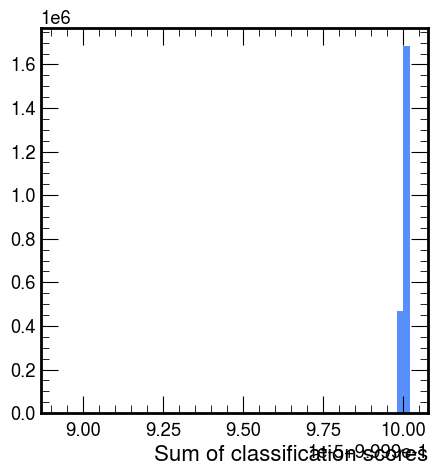

In [54]:
fig, ax = plt.subplots(1,1,figsize=[5,5])
#ax.hist(scores_sum, bins=50, range=(0.8,1.2));
ax.hist(scores_sum, bins=50)
ax.set_xlabel("Sum of classification scores");

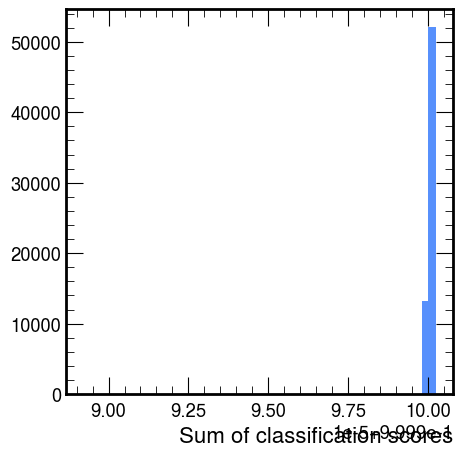

In [55]:
w = df_test["WEIGHTS/weight"][:]
fig, ax = plt.subplots(1,1,figsize=[5,5])
#ax.hist(scores_sum, bins=50, range=(0.8,1.2));
ax.hist(scores_sum, bins=50, weights=w)
ax.set_xlabel("Sum of classification scores");

In [56]:
def plot_score(pred_label, score, label, ax, weights=None, title=None, mask=None, log=False, ylim=None, density=False):
    if type(mask) != type(None):
        pred_label = pred_label[mask]
        if type(weights) != type(None):
            weights = weights[mask]
    n, bins, patches = ax.hist(pred_label, bins=50, range=(0,1), weights=weights, histtype="step", linewidth=2, label=label, density=density)
    ax.legend()
    ax.set_xlabel(f"{score} SPANet score")
    if density:
        ax.set_ylabel("A.U.")
    else:
        ax.set_ylabel("Counts")
    if log:
        ax.set_yscale("log")
    if ylim != None:
        ax.set_ylim(*ylim)
    if title:
        ax.set_title(title)
    return n, bins, patches

def plot_scores(true_labels, pred_labels, weights=None, title=None, mask=None, log=False, ylim=None, density=False):
    fig, axes = plt.subplots(2, 2, figsize=[10,10])
    for i, score in enumerate(labels):
        ax = axes[i%2][int(i/2)]
        for j, label in enumerate(labels):
            mask_by_sample = true_labels[label]
            if type(mask) != type(None):
                mask_by_sample = mask_by_sample & mask
            if type(weights) != type(None):
                plot_score(pred_labels[score], score, label, mask=mask_by_sample, ax=ax, weights=weights, title=title, log=log, ylim=ylim, density=density)
            else:
                plot_score(pred_labels[score], score, label, mask=mask_by_sample, ax=ax, title=title, log=log, ylim=ylim, density=density)
        fig.tight_layout(pad=1.5)

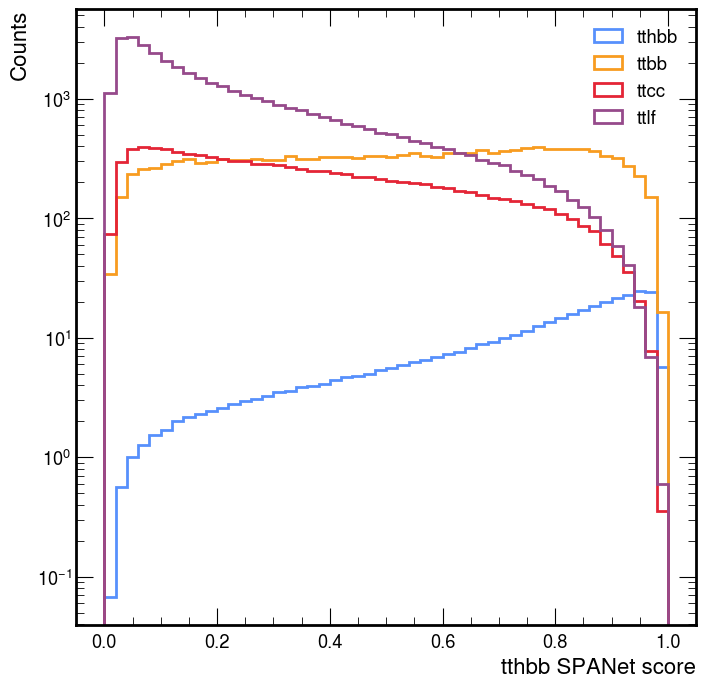

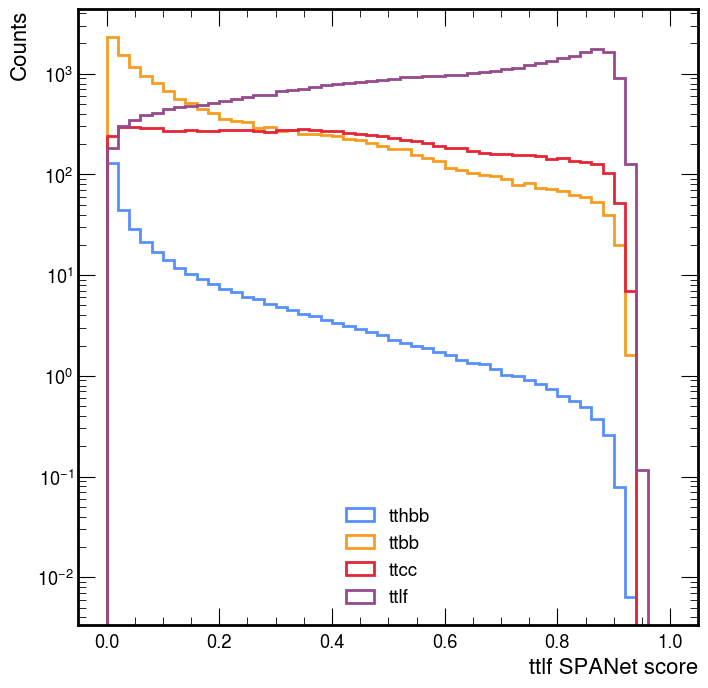

In [57]:
for score_to_plot in ["tthbb", "ttlf"]:
    fig, ax = plt.subplots(1,1, figsize=[8,8])
    for j, label in enumerate(labels):
        mask_by_sample = true_labels[label]
        plot_score(pred_labels[score_to_plot], score_to_plot, label, mask=mask_by_sample, ax=ax, weights=weights, log=True)
    filename = os.path.join(plots_folder, f"score_{score_to_plot}.png")
    plt.savefig(filename, dpi=300)

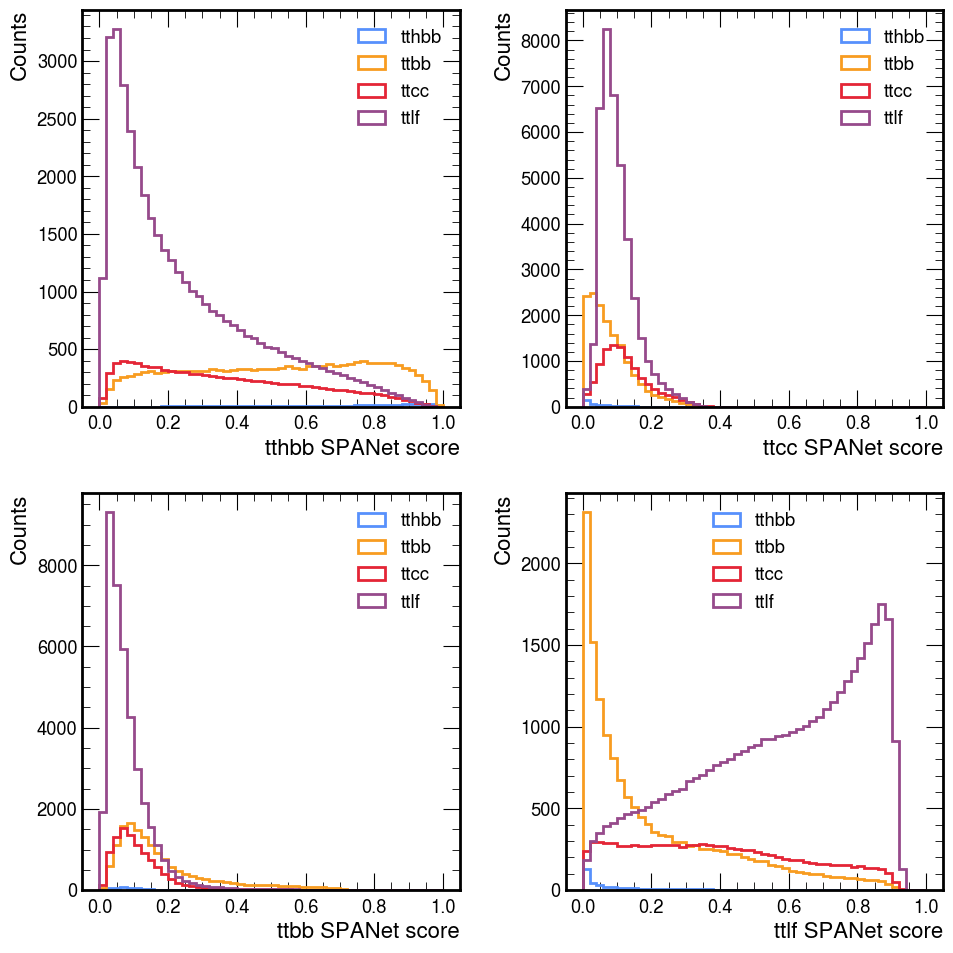

In [58]:
plot_scores(true_labels, pred_labels, weights=weights)

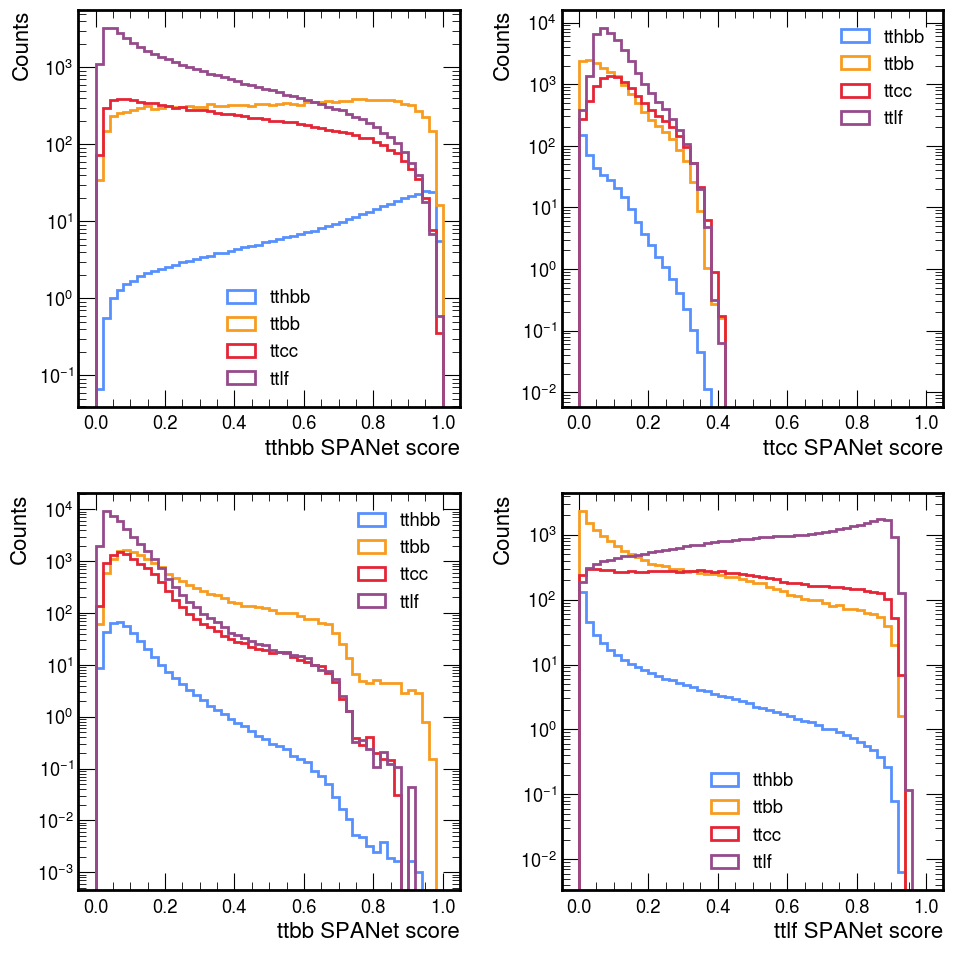

In [59]:
plot_scores(true_labels, pred_labels, weights=weights, log=True)

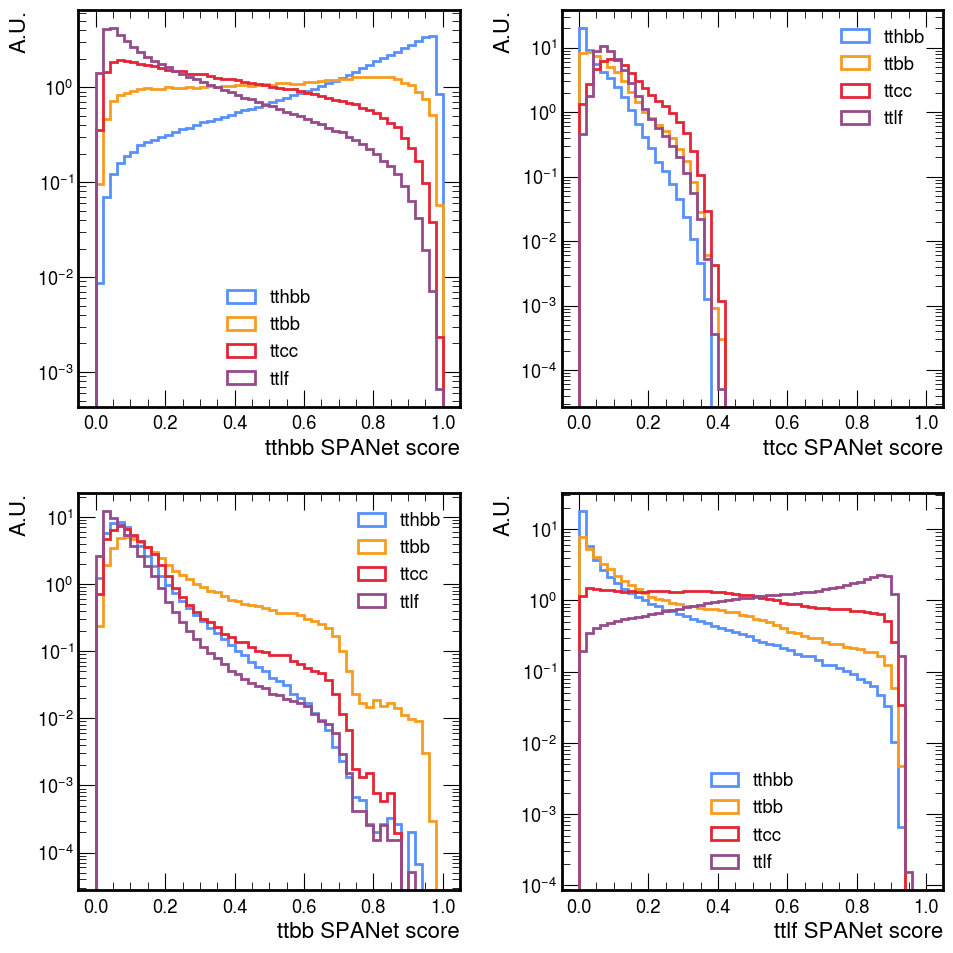

In [60]:
plot_scores(true_labels, pred_labels, density=True, log=True)

In [61]:
def plot_roc(true_label, pred_label, ax, label, weight=None):
    fpr, tpr, thresholds = roc_curve(true_label, pred_label, sample_weight=weight)
    i_sorted = np.argsort(fpr)
    AUC = auc(fpr[i_sorted], tpr[i_sorted])
    ax.plot(tpr, fpr, label=f"{label} AUC={round(AUC, 3)}")
    ax.set_yscale("log")
    ax.set_title(f"{label} score")
    ax.set_xlabel("Signal efficiency")
    ax.set_ylabel("Background efficiency")
    ax.legend()

def plot_rocs(true_labels, pred_labels, weight=None):
    fig, axes = plt.subplots(2, 2, figsize=[10,10])
    for i, label in enumerate(labels):
        ax = axes[i%2][int(i/2)]
        true_label = true_labels[label]
        pred_label = pred_labels[label]
        plot_roc(true_label, pred_label, ax, label)
        plot_roc(true_label, pred_label, ax, label+" weighed", weight=weight)
    fig.tight_layout(pad=1.5)

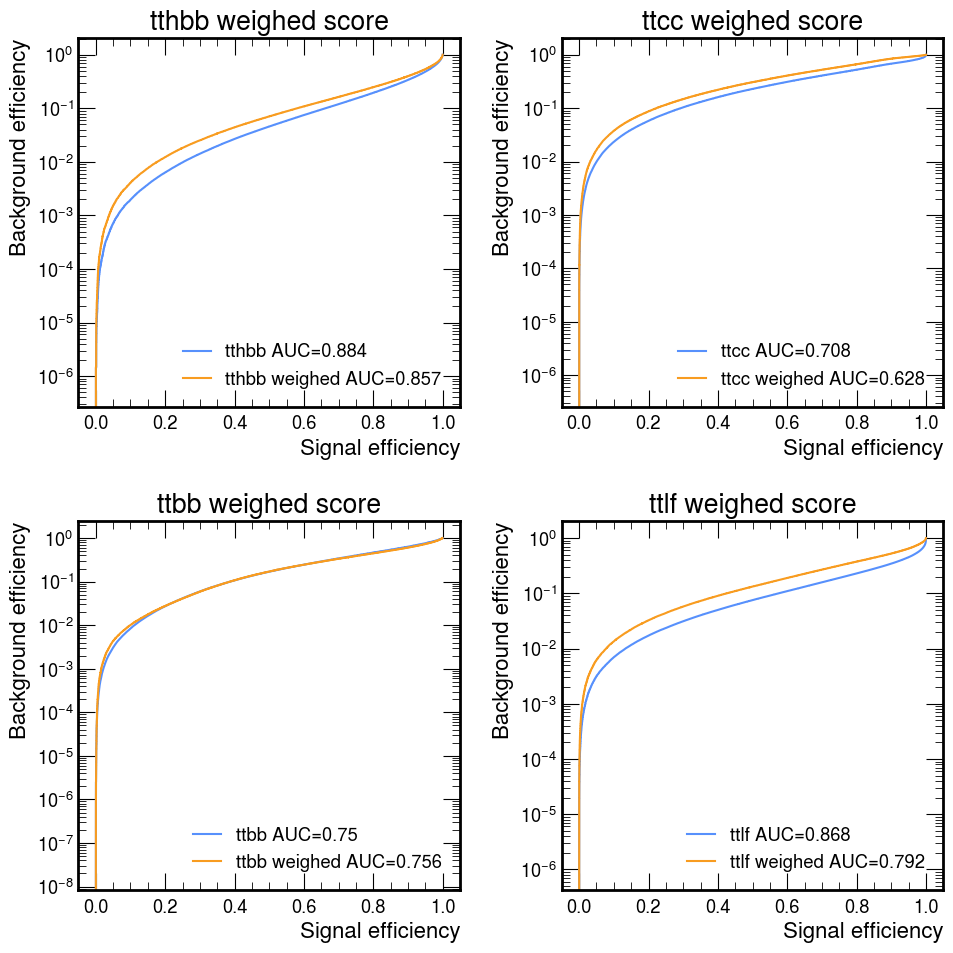

In [62]:
weight = df_test["WEIGHTS/weight"][:]
plot_rocs(true_labels, pred_labels, weight=weight)

## Evaluate the performance on ttHbb + tt+bb only
We select only true ttHbb and tt+bb events in order to evaluate the performance of the tagger on ttHbb vs tt+bb.

In [63]:
is_tthbb_or_ttbb = true_labels["tthbb"] | true_labels["ttbb"]
is_tthbb_or_ttbb

array([False,  True, False, ...,  True, False, False])

In [64]:
true_label = true_labels["tthbb"]
pred_label = pred_labels["tthbb"]
true_label_tthbb_or_ttbb = true_label[is_tthbb_or_ttbb]
score = pred_label[is_tthbb_or_ttbb]
weight_tthbb_or_ttbb = df_test["WEIGHTS/weight"][is_tthbb_or_ttbb]
score

array([0.88089937, 0.57853323, 0.9324827 , ..., 0.63455206, 0.70761675,
       0.9015367 ], dtype=float32)

In [65]:
len(pred_label), len(score), len(score) / len(pred_label)

(2152028, 918628, 0.42686619319079494)

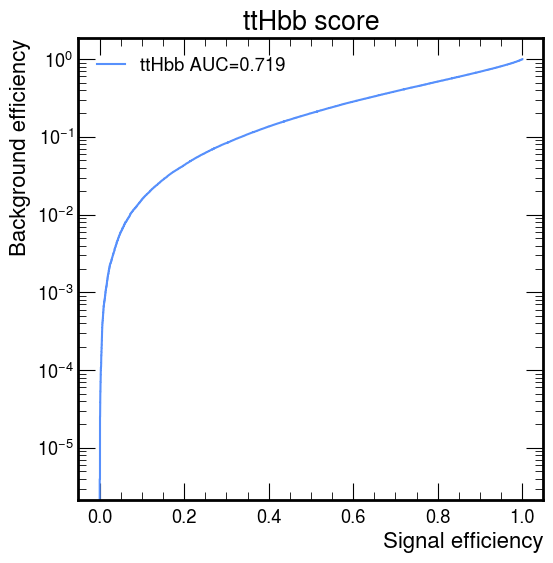

In [66]:
label = "ttHbb"
fig, ax = plt.subplots(1, 1, figsize=[6,6])
plot_roc(true_label_tthbb_or_ttbb, score, ax, label, weight=weight_tthbb_or_ttbb)

## Evaluate the performance on ttHbb + tt+bb with optimal discriminator
In order to discriminate between the ttHbb and tt+bb hypotheses, we know that we can build the optimal discriminator as:

$prob(\text{ttHbb vs tt+bb}) = \frac{prob(ttHbb)}{prob(ttHbb) + prob(tt+bb)}$

In [67]:
true_label = true_labels["tthbb"]
pred_label = pred_labels["tthbb"] / (pred_labels["tthbb"] + pred_labels["ttbb"])
optimal_score = pred_label[is_tthbb_or_ttbb]
optimal_score

array([0.9073152 , 0.87936765, 0.9393671 , ..., 0.86323243, 0.8353919 ,
       0.9420758 ], dtype=float32)

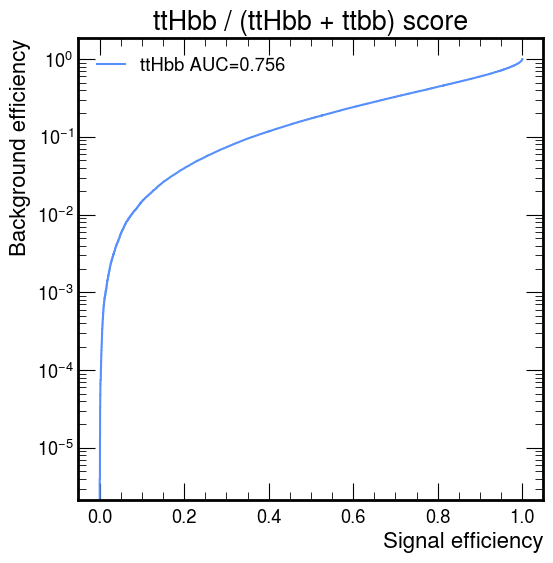

In [68]:
label = "ttHbb"
fig, ax = plt.subplots(1, 1, figsize=[6,6])
plot_roc(true_label_tthbb_or_ttbb, optimal_score, ax, label, weight=weight_tthbb_or_ttbb)
ax.set_title("ttHbb / (ttHbb + ttbb) score");

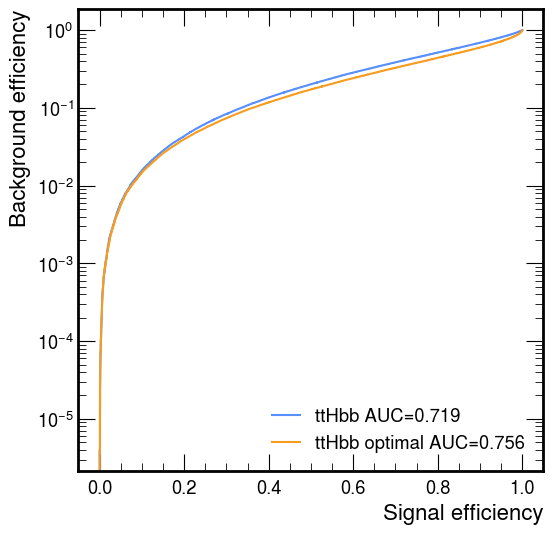

In [69]:
fig, ax = plt.subplots(1, 1, figsize=[6,6])
plot_roc(true_label_tthbb_or_ttbb, score, ax, "ttHbb", weight=weight_tthbb_or_ttbb)
plot_roc(true_label_tthbb_or_ttbb, optimal_score, ax, "ttHbb optimal", weight=weight_tthbb_or_ttbb)
ax.set_title("");

In [70]:
def plot_correlation(score1, score2, label1, label2, ax, weights=None):
    #ax.hist2d(score1, score2, bins=(10,10), range=((0,1),(0,1)), norm=matplotlib.colors.LogNorm())
    _,_,_,I = ax.hist2d(score1, score2, bins=(10,10), range=((0,1),(0,1)), cmin=1e-5, weights=weights)
    ax.set_xlabel(label1)
    ax.set_ylabel(label2)
    plt.colorbar(I, ax=ax)

def plot_correlations(pred_labels, mask=None, weights=None):
    fig, axes = plt.subplots(4, 4, figsize=[12,10])
    for i, label1 in enumerate(labels):
        for j, label2 in enumerate(labels):
            ax = axes[j][i]
            if i > j:
                ax.axis('off')
                continue
            pred_label1 = pred_labels[label1]
            pred_label2 = pred_labels[label2]
            if type(mask) != None:
                pred_label1 = pred_label1[mask]
                pred_label2 = pred_label2[mask]
                weights_masked = weights[mask]
            plot_correlation(pred_label1, pred_label2, label1, label2, ax, weights=weights_masked)
           
    fig.tight_layout(pad=0.5)

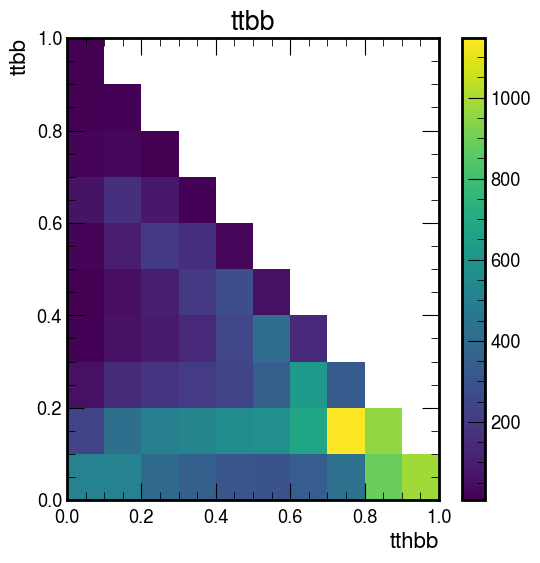

In [71]:
fig, ax = plt.subplots(1, 1, figsize=[6,6])
label1 = "tthbb"
label2 = "ttbb"
is_tthbb = true_labels["tthbb"]
is_ttbb = true_labels["ttbb"]
is_ttcc = true_labels["ttcc"]
is_ttlf = true_labels["ttlf"]
score1 = pred_labels[label1][is_ttbb]
score2 = pred_labels[label2][is_ttbb]
weights_ttbb = df_test["WEIGHTS/weight"][is_ttbb]
plot_correlation(score1, score2, label1, label2, ax, weights_ttbb)
ax.set_title("ttbb");

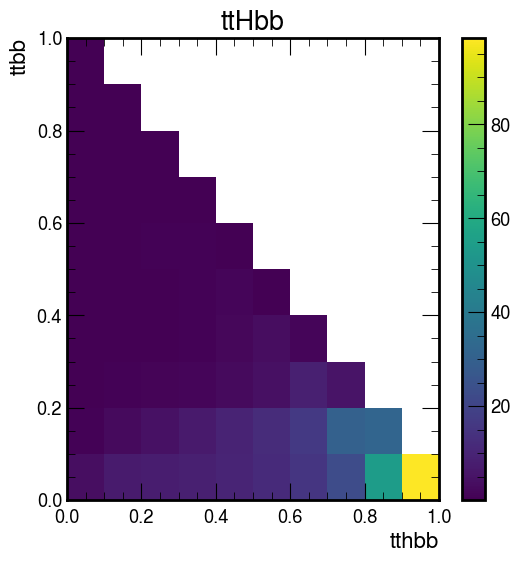

In [72]:
score1 = pred_labels[label1][is_tthbb]
score2 = pred_labels[label2][is_tthbb]
weights_tthbb = df_test["WEIGHTS/weight"][is_tthbb]
fig, ax = plt.subplots(1, 1, figsize=[6,6])
plot_correlation(score1, score2, label1, label2, ax, weights_tthbb)
ax.set_title("ttHbb");

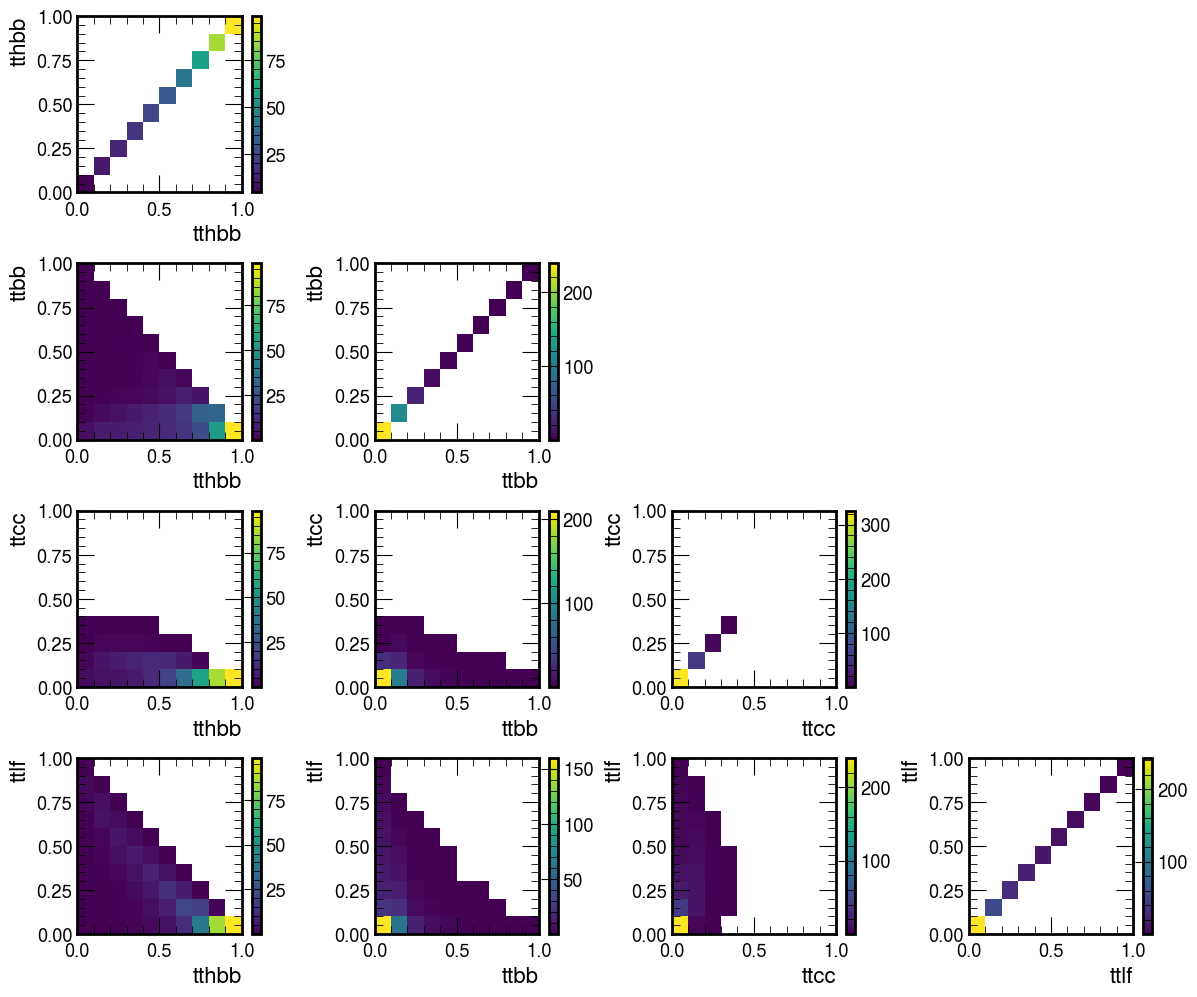

In [73]:
plot_correlations(pred_labels, mask=is_tthbb, weights=df_test["WEIGHTS/weight"])

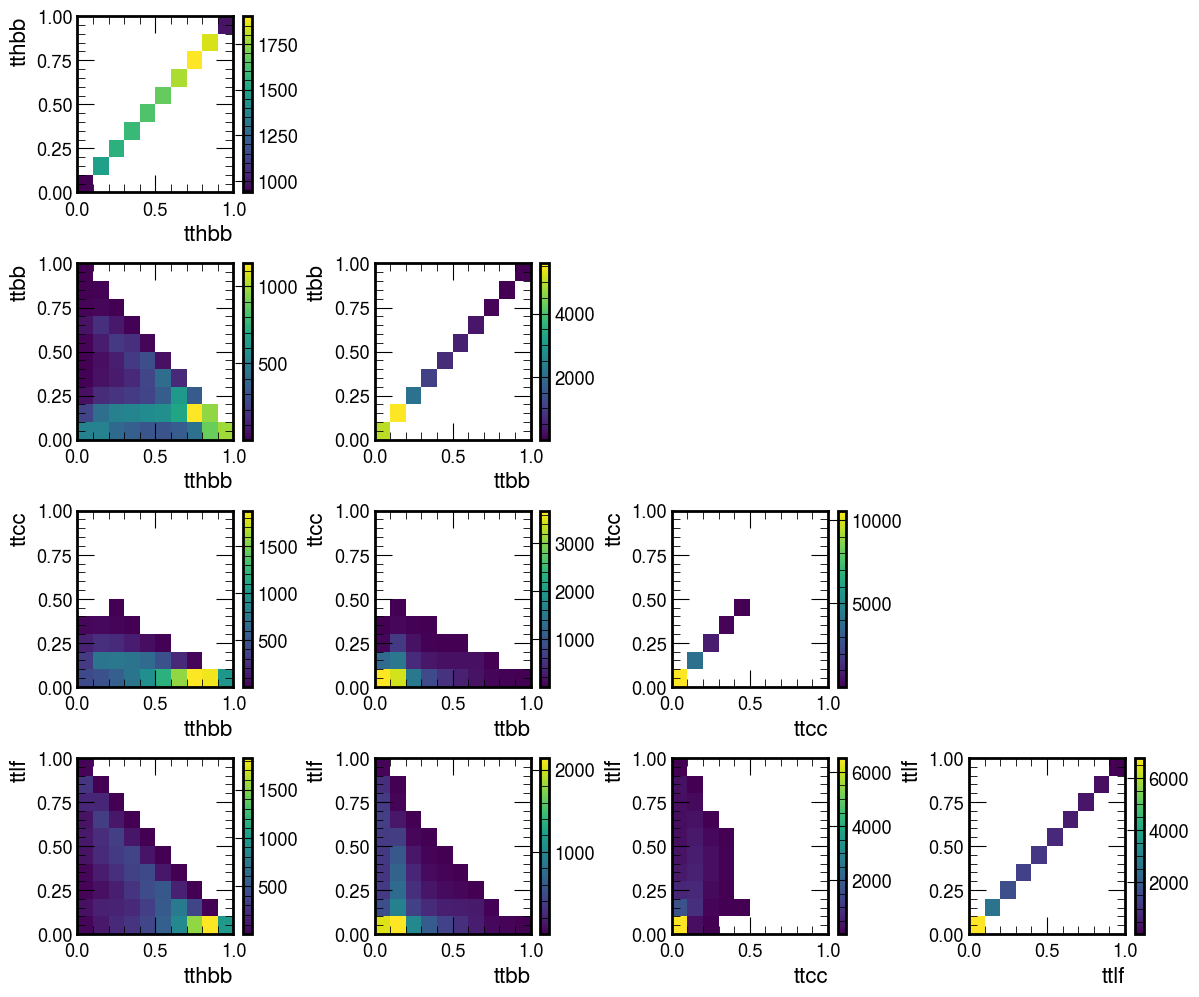

In [74]:
plot_correlations(pred_labels, mask=is_ttbb, weights=df_test["WEIGHTS/weight"])

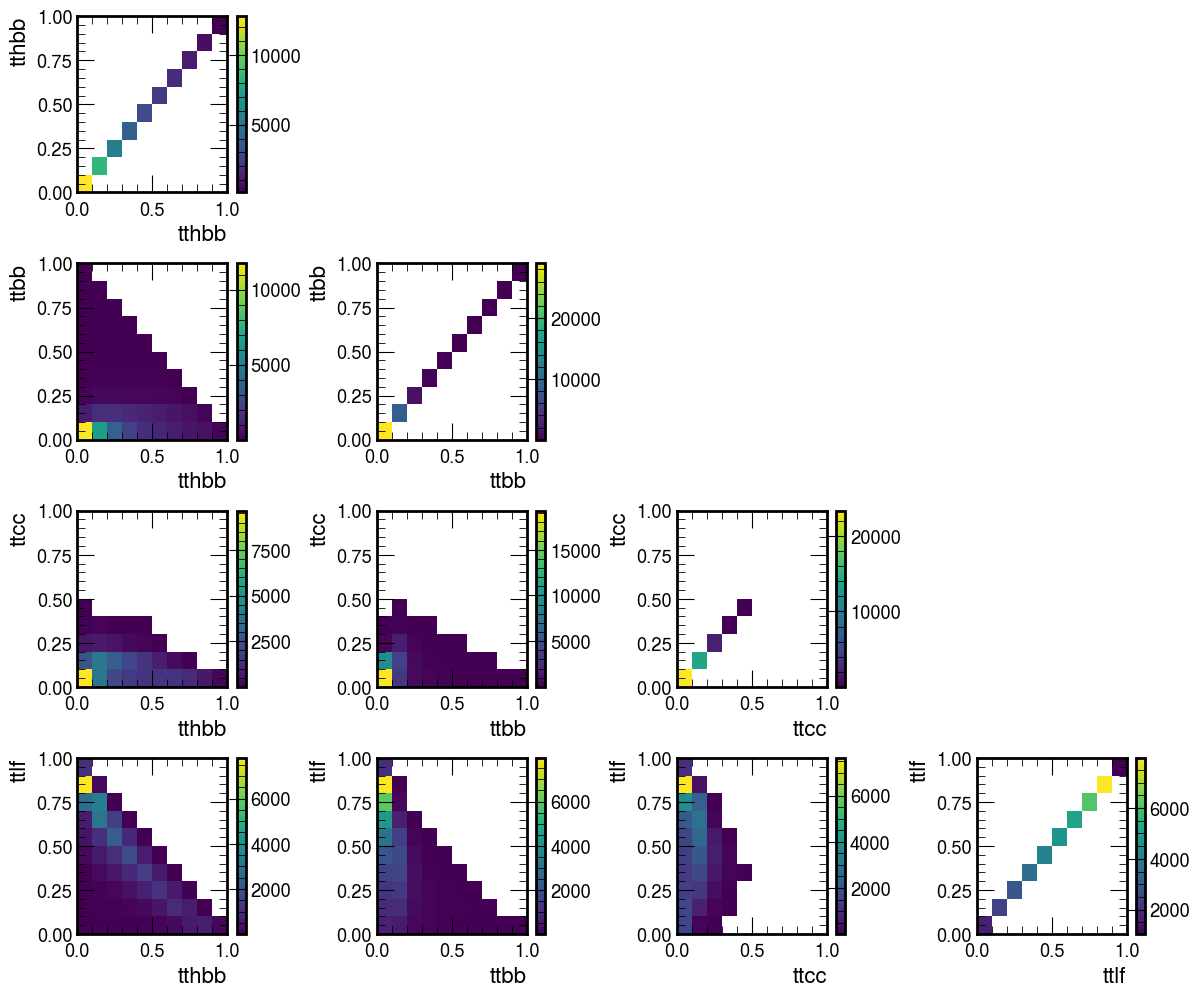

In [75]:
plot_correlations(pred_labels, mask=is_ttlf, weights=df_test["WEIGHTS/weight"])

In [76]:
edges = [0, 0.15, 0.25, 0.3, 0.4, 0.6, 0.8, 1.0]
bins = [(edges[i], edges[i+1]) for i in range(len(edges[:-1]))]
label = "ttbb"
masks_ttbb = {}
for lo, hi in bins:
    masks_ttbb[f"{lo}_{hi}"] = (pred_labels[label] > lo) & (pred_labels[label] < hi)
masks_ttbb

{'0_0.15': array([ True,  True,  True, ...,  True,  True,  True]),
 '0.15_0.25': array([False, False, False, ..., False, False, False]),
 '0.25_0.3': array([False, False, False, ..., False, False, False]),
 '0.3_0.4': array([False, False, False, ..., False, False, False]),
 '0.4_0.6': array([False, False, False, ..., False, False, False]),
 '0.6_0.8': array([False, False, False, ..., False, False, False]),
 '0.8_1.0': array([False, False, False, ..., False, False, False])}

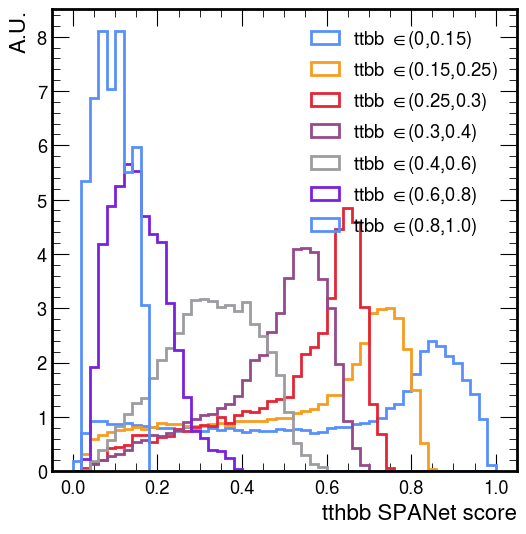

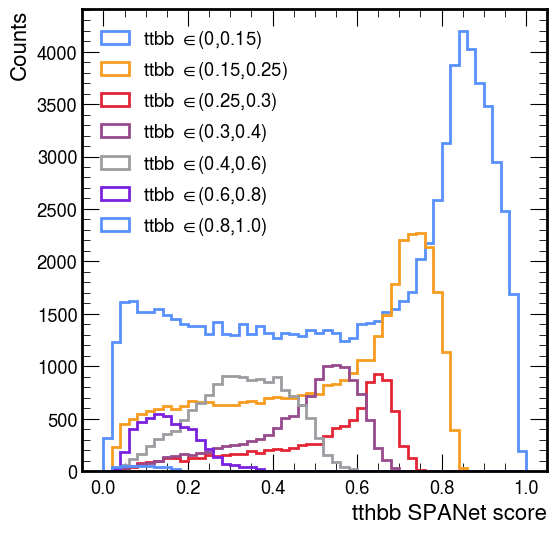

In [77]:
for density in [True, False]:
    for score in ["tthbb"]:
        fig, ax = plt.subplots(1,1,figsize=[6,6])
        for name, mask in masks_ttbb.items():
            plot_score(pred_labels[score][is_ttbb & mask], score, f"ttbb $\in$({','.join(name.split('_'))})", ax, density=density)

# Transform the classifier score

In [78]:
from sklearn.preprocessing import QuantileTransformer

In [79]:
mask_by_sample = true_labels["tthbb"]
score = pred_labels["tthbb"][mask_by_sample]
score

array([0.88089937, 0.57853323, 0.9324827 , ..., 0.63455206, 0.70761675,
       0.9015367 ], dtype=float32)

In [80]:
import numpy as np
from scipy.stats import norm
from sklearn.base import BaseEstimator, TransformerMixin

class WeightedQuantileTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_quantiles=1000, output_distribution='normal'):
        self.n_quantiles = n_quantiles
        self.output_distribution = output_distribution
    
    def _weighted_quantiles(self, X, weights):
        # Calculate weighted quantiles
        sorted_indices = np.argsort(X)
        X_sorted = X[sorted_indices]
        weights_sorted = weights[sorted_indices]
        cum_weights = np.cumsum(weights_sorted) / np.sum(weights_sorted)
        
        # Interpolate to get quantiles
        quantiles = np.interp(np.linspace(0, 1, self.n_quantiles), cum_weights, X_sorted)
        return quantiles
    
    def fit(self, X, y=None, sample_weight=None):
        if sample_weight is None:
            raise ValueError("Sample weights must be provided.")
        
        self.quantiles_ = self._weighted_quantiles(X, sample_weight)
        
        if self.output_distribution == 'normal':
            self.reference_quantiles_ = norm.ppf(np.linspace(0, 1, self.n_quantiles))
        elif self.output_distribution == 'uniform':
            self.reference_quantiles_ = np.linspace(0, 1, self.n_quantiles)
        else:
            raise ValueError(f"Unknown output distribution '{self.output_distribution}'.")
        
        return self
    
    def transform(self, X):
        # Interpolate based on weighted quantiles
        transformed_X = np.interp(X, self.quantiles_, self.reference_quantiles_)
        return transformed_X

transformer = WeightedQuantileTransformer(n_quantiles=10000, output_distribution='uniform')
X = score
transformer.fit(X, sample_weight=weights[mask_by_sample])
transformed_X = transformer.transform(X)

In [81]:
transformed_X.shape

(752114,)

In [82]:
qt = QuantileTransformer(n_quantiles=10000, random_state=0, subsample=10**6)
qt

QuantileTransformer(n_quantiles=10000, random_state=0, subsample=1000000)

In [83]:
from copy import deepcopy
qt_signal = qt.fit(score.reshape(-1,1))
# Update the tthbb score
pred_labels_new = deepcopy(pred_labels)
#pred_labels_new["tthbb"] = np.ravel(qt_signal.transform(pred_labels["tthbb"].reshape(-1,1)))
pred_labels_new["tthbb"] = np.ravel(transformer.transform(pred_labels["tthbb"].reshape(-1,1)))
qt_signal

QuantileTransformer(n_quantiles=10000, random_state=0, subsample=1000000)

In [84]:
weights.shape

(2152028,)

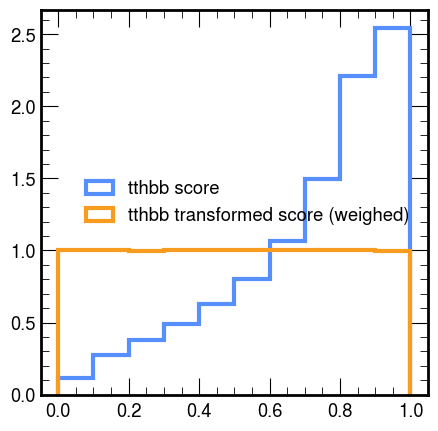

In [85]:
fig, ax = plt.subplots(1,1, figsize=[5,5])
ax.hist(score, weights=weights[mask_by_sample], bins=10, range=(0,1), histtype="step", linewidth=3, label="tthbb score", density=True)
#ax.hist(qt_signal.transform(score.reshape(-1,1)), bins=10, range=(0,1), histtype="step", linewidth=3, label="tthbb transformed score", density=True)
ax.hist(transformed_X, weights=weights[mask_by_sample], bins=10, range=(0,1), histtype="step", linewidth=3, label="tthbb transformed score (weighed)", density=True)
ax.legend();

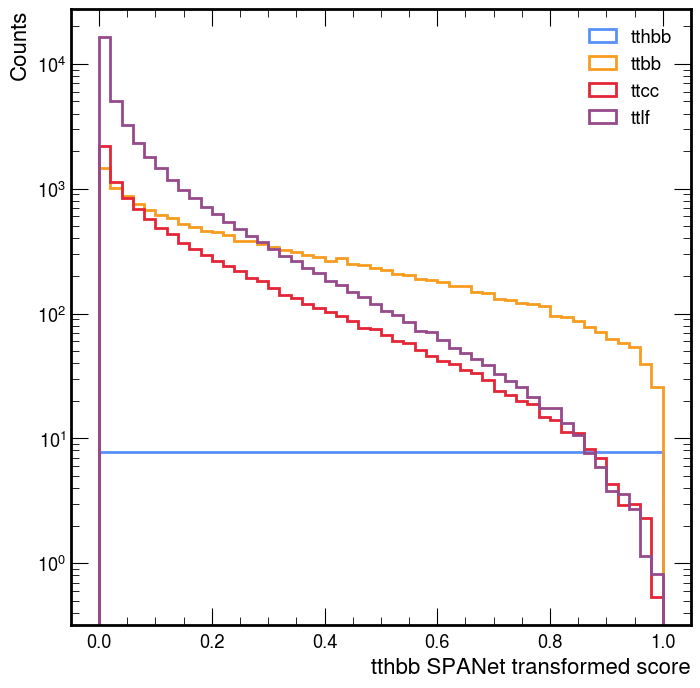

In [86]:
score_to_plot = "tthbb"
fig, ax = plt.subplots(1,1, figsize=[8,8])
for j, label in enumerate(labels):
    mask_by_sample = true_labels[label]
    plot_score(pred_labels_new[score_to_plot], score_to_plot, label, mask=mask_by_sample, ax=ax, weights=weights, log=True)
ax.set_xlabel("tthbb SPANet transformed score")
filename = os.path.join(plots_folder, f"score_{score_to_plot}_transformed.png")
plt.savefig(filename, dpi=300)

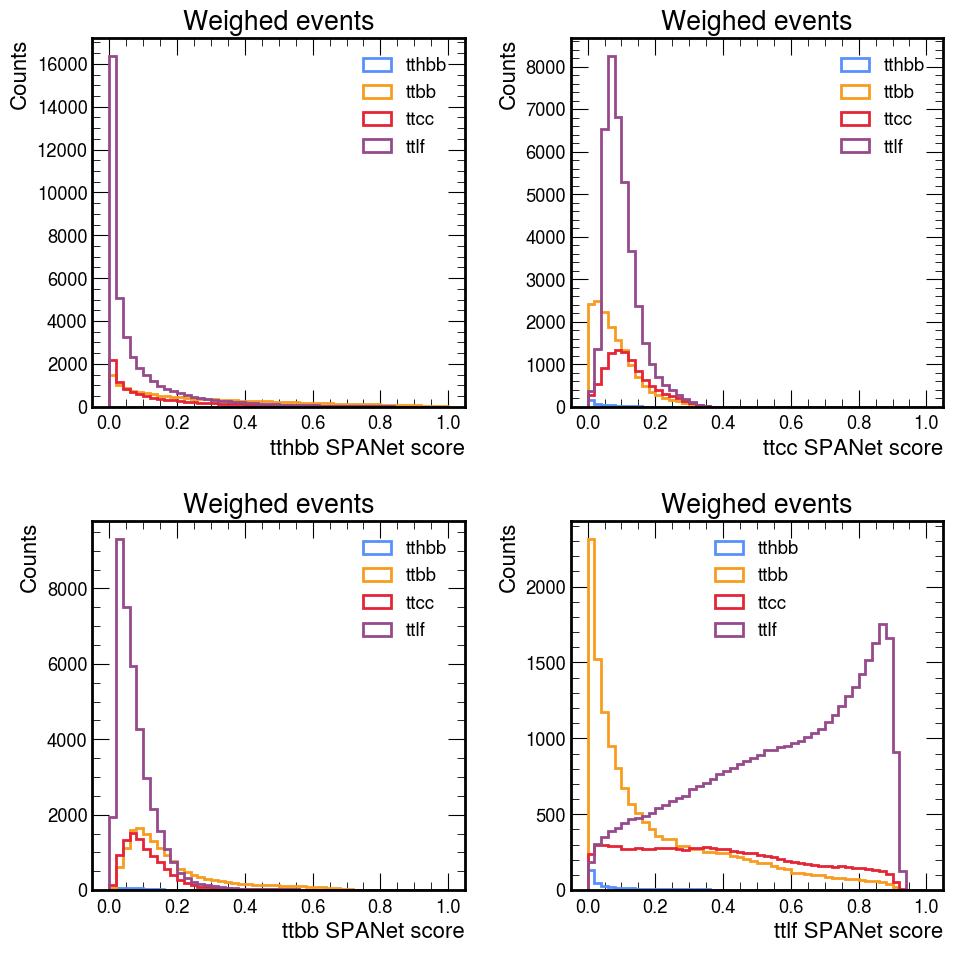

In [87]:
plot_scores(true_labels, pred_labels_new, weights=weights, title="Weighed events")

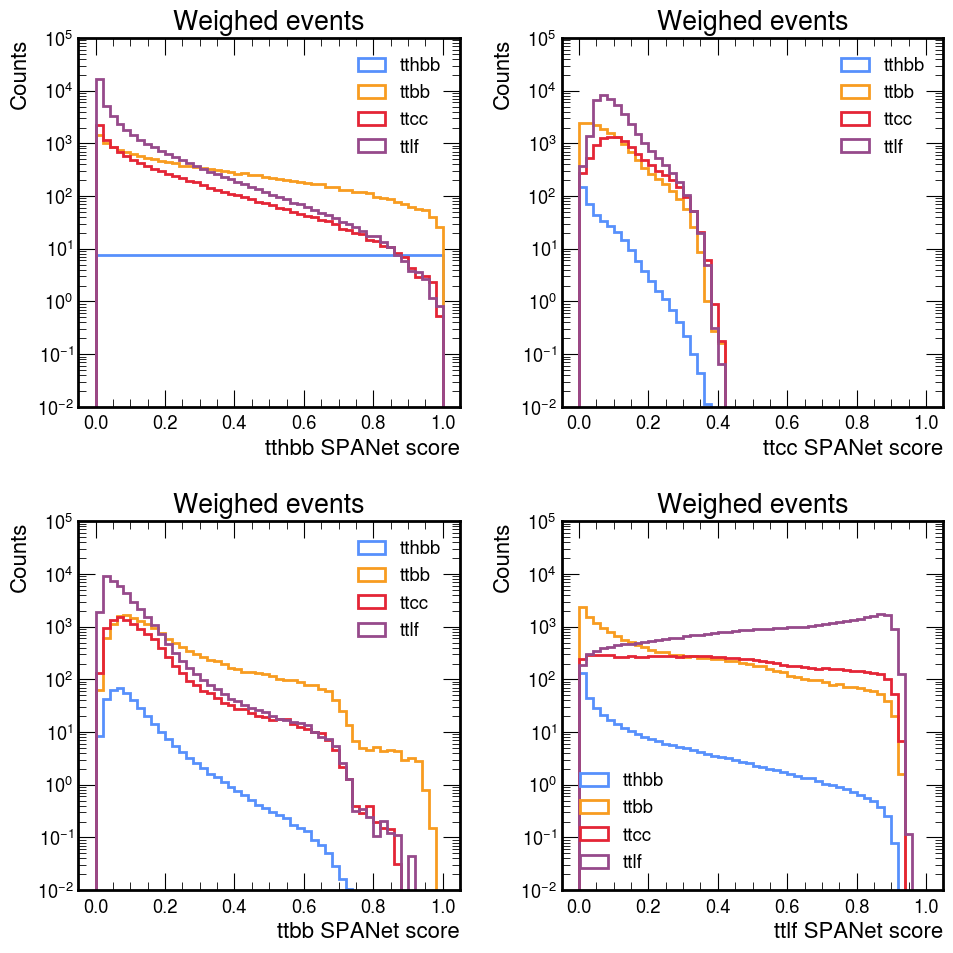

In [88]:
plot_scores(true_labels, pred_labels_new, weights=weights, title="Weighed events", ylim=(0.01, 10**5), log=True)

# Control regions

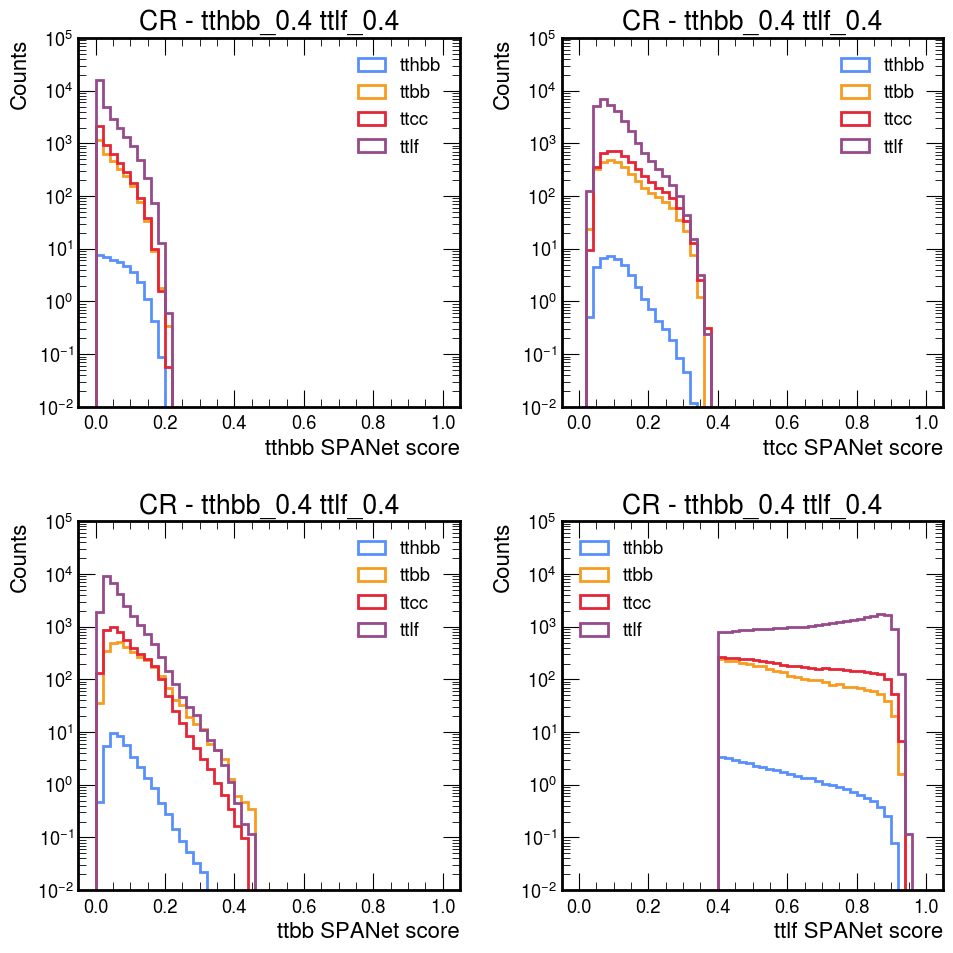

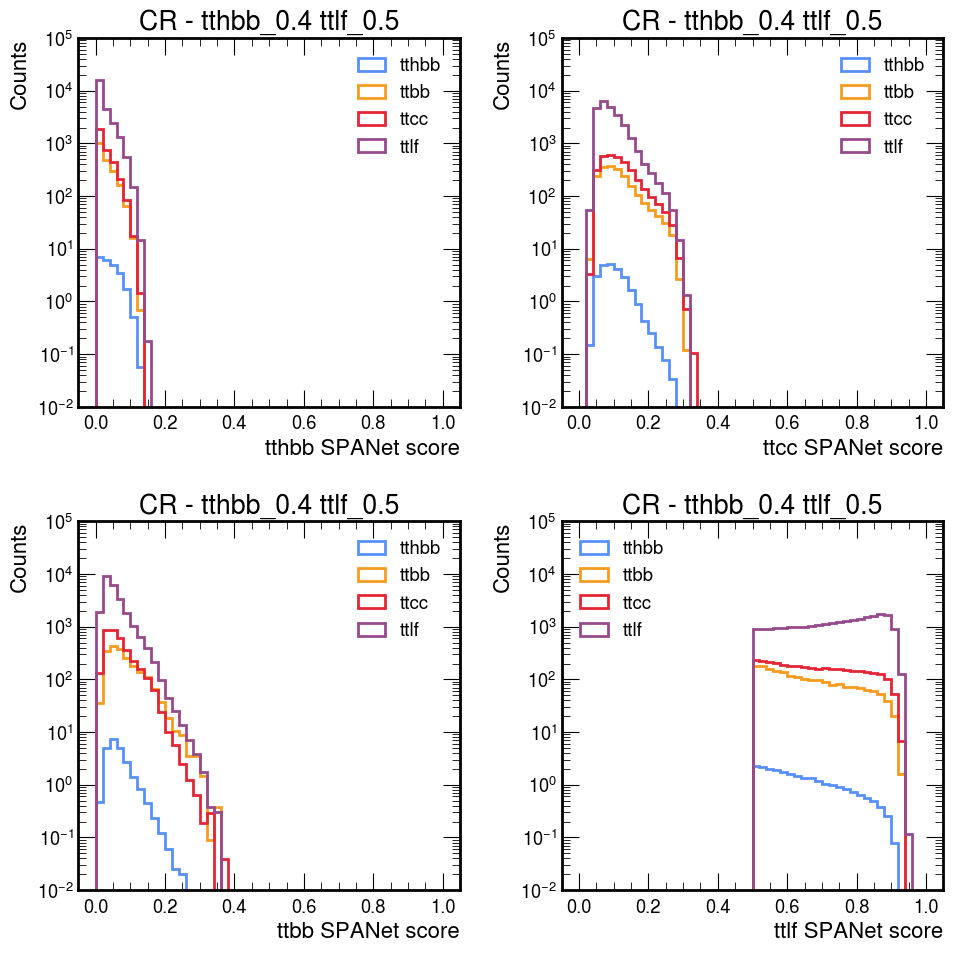

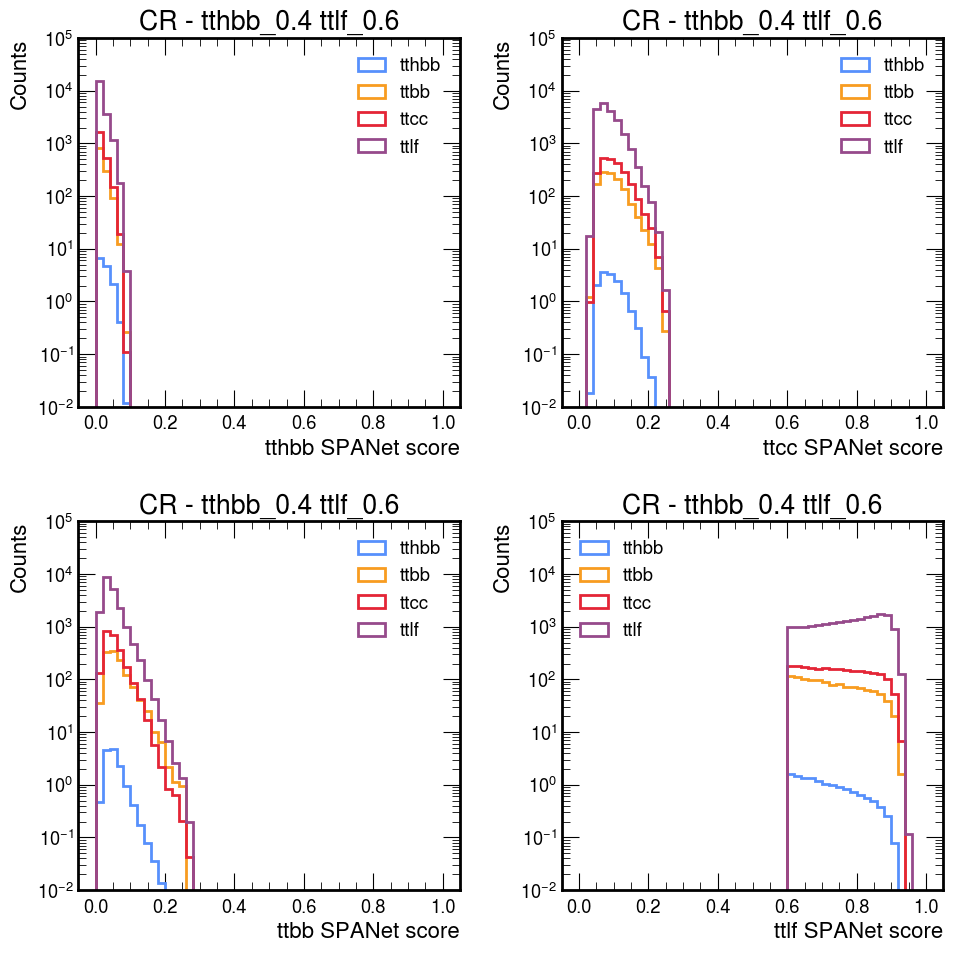

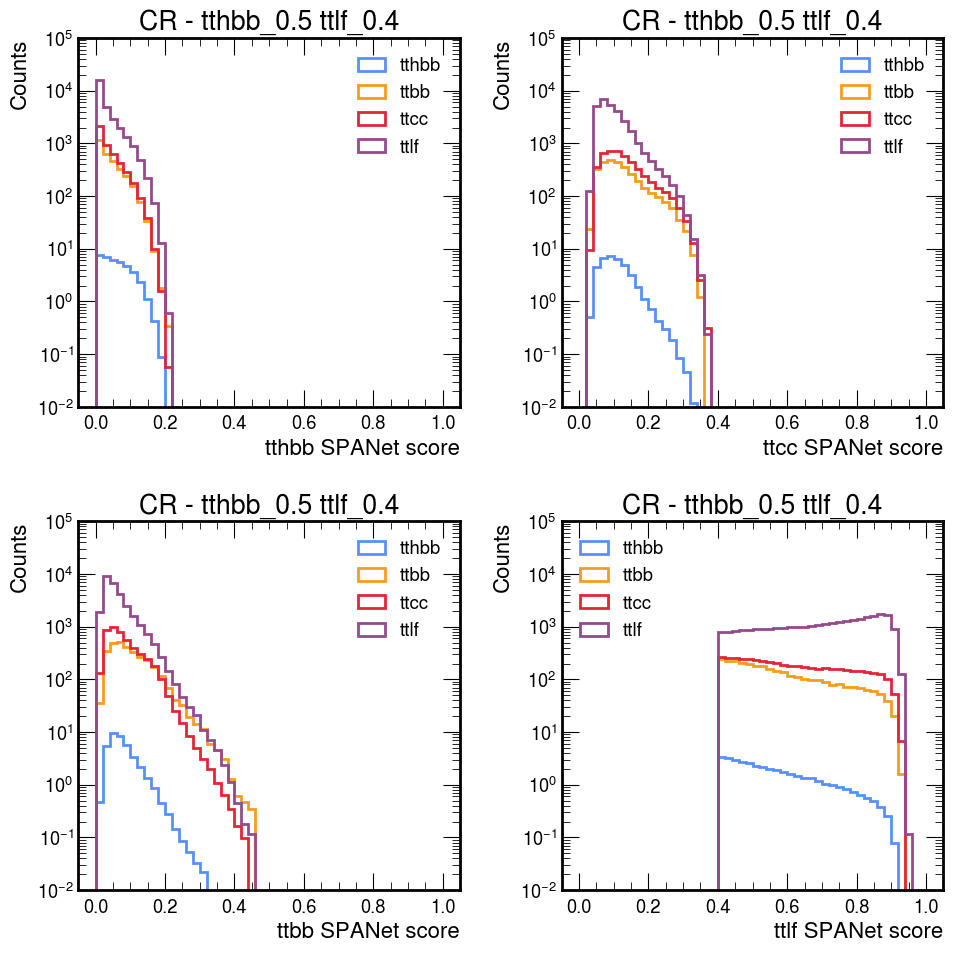

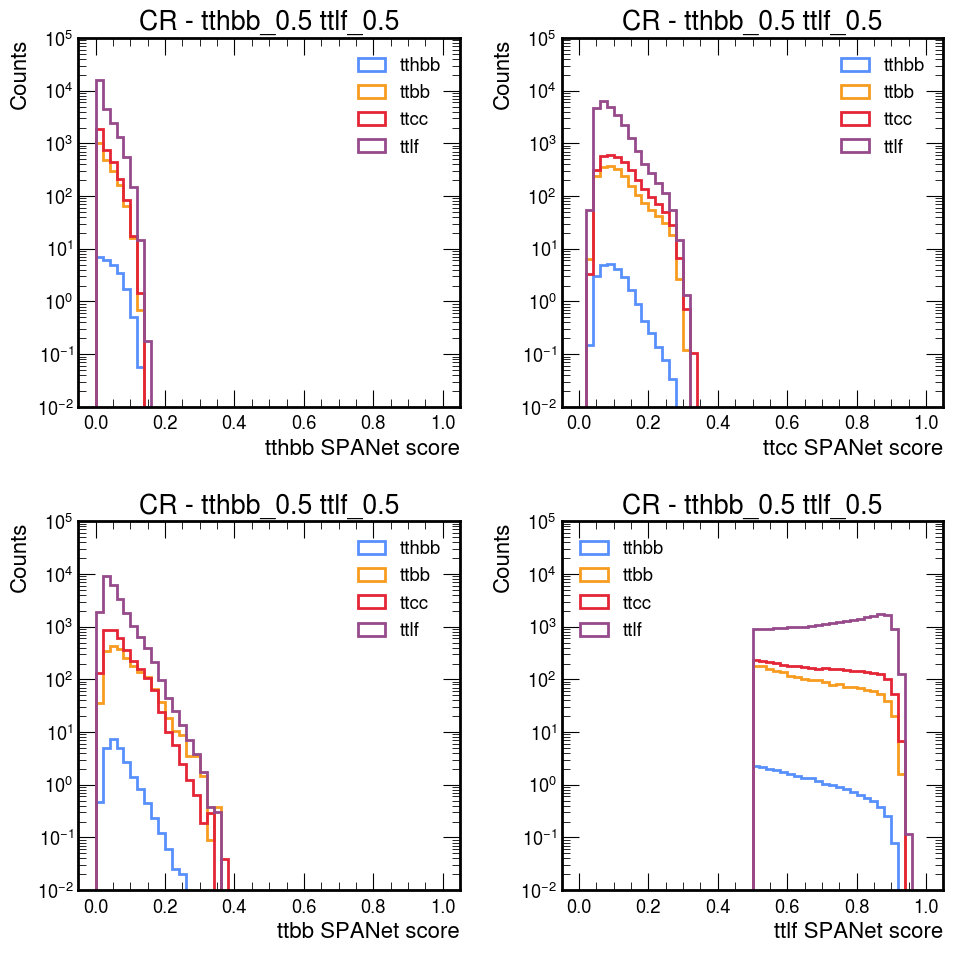

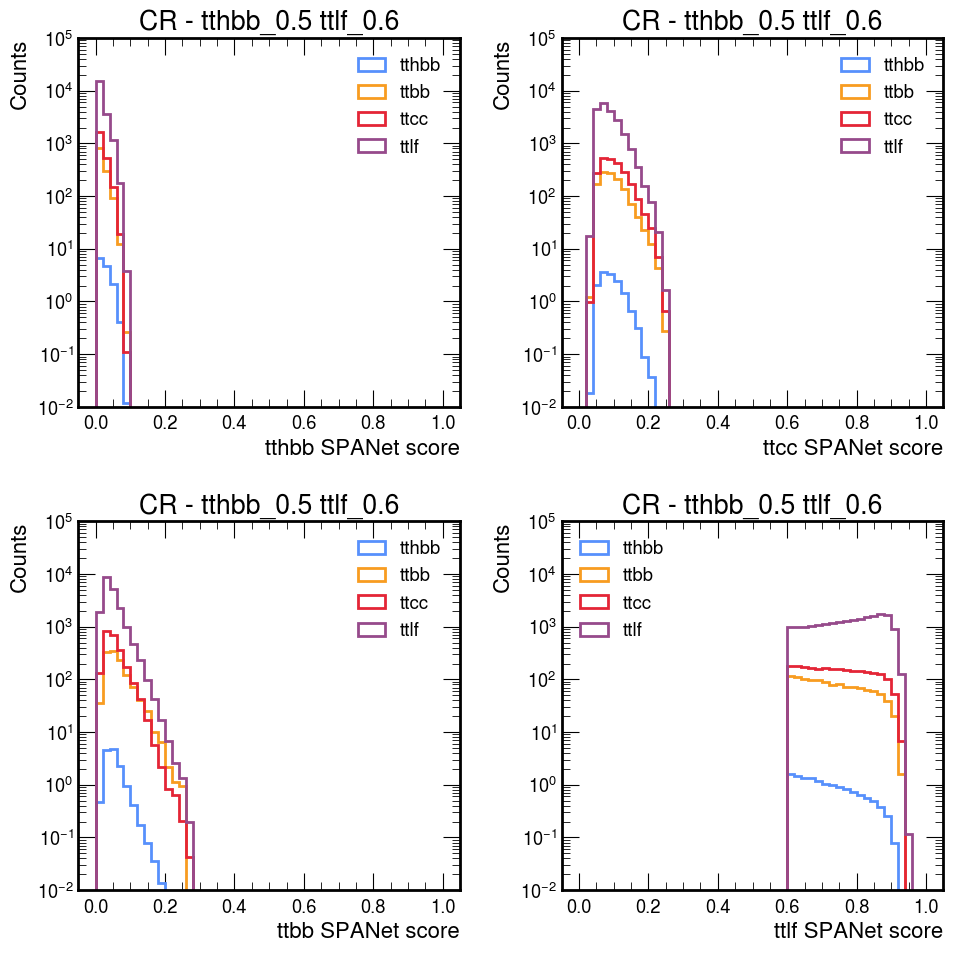

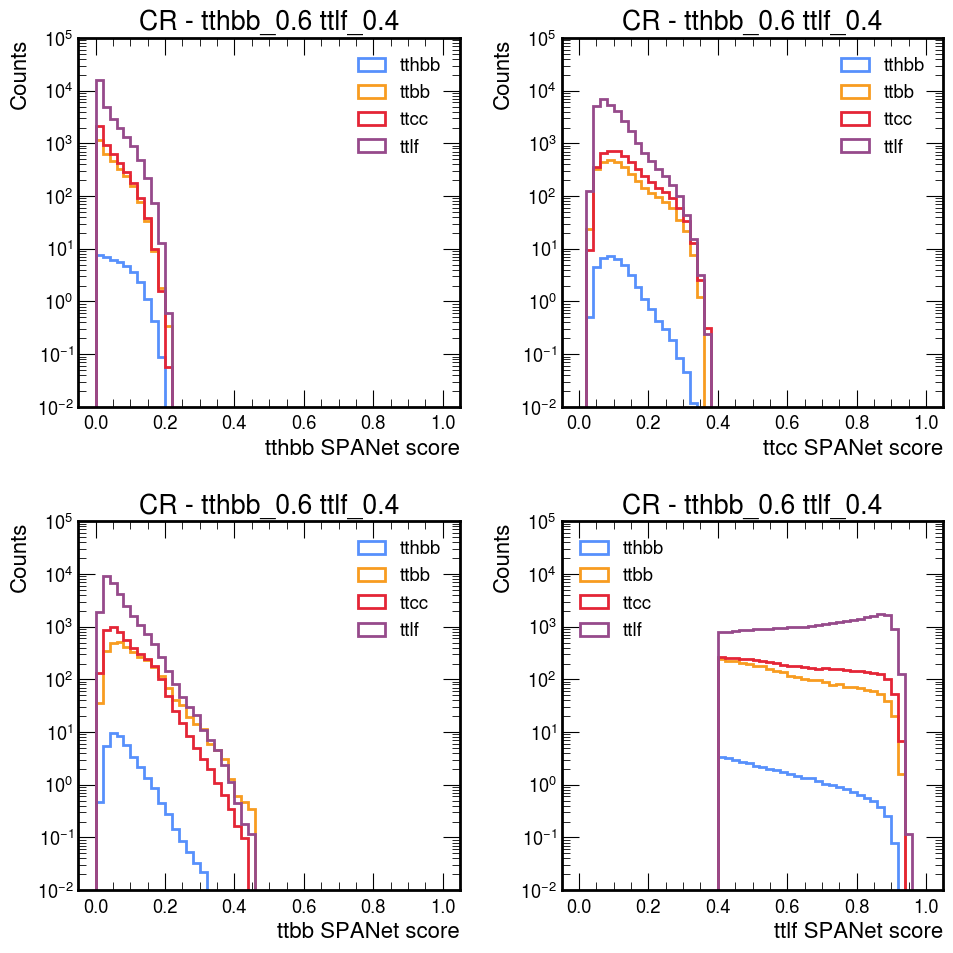

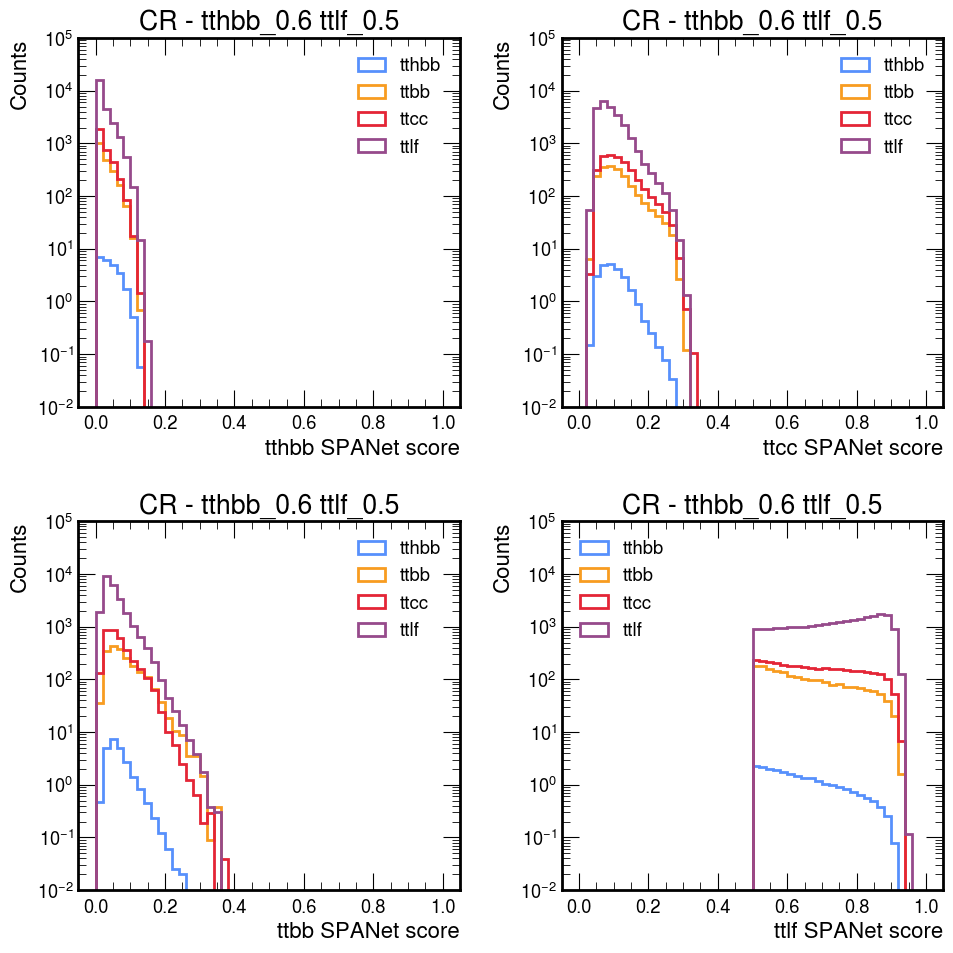

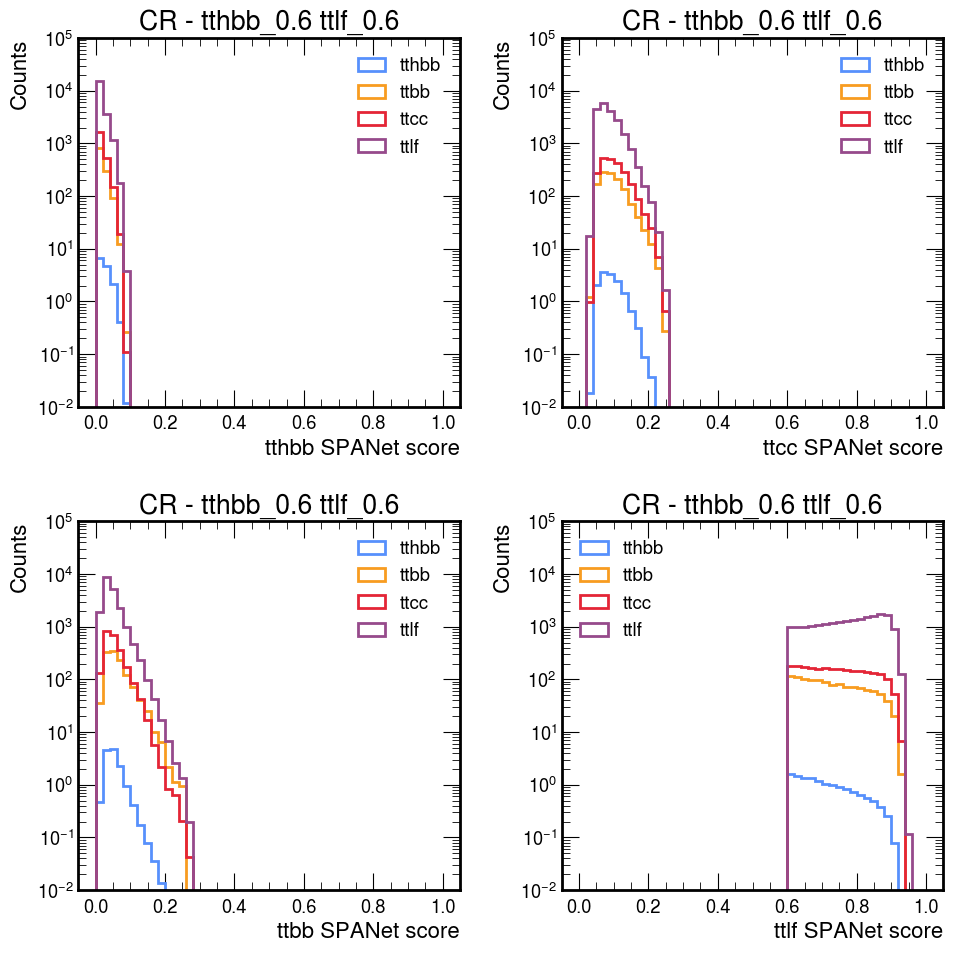

In [89]:
tthbb = pred_labels_new["tthbb"]
for tthbb_max in [0.4, 0.5, 0.6]:
    mask_tthbb_max_06 = tthbb < tthbb_max
    for ttlf_min in [0.4, 0.5, 0.6]:
        mask_ttlf_min_06 = ttlf > ttlf_min
        mask_CR = mask_tthbb_max_06 & mask_ttlf_min_06
        plot_scores(true_labels, pred_labels_new, mask=mask_CR, weights=weights, title=f"CR - tthbb_{tthbb_max} ttlf_{ttlf_min}", ylim=(0.01, 10**5), log=True)

# Signal regions

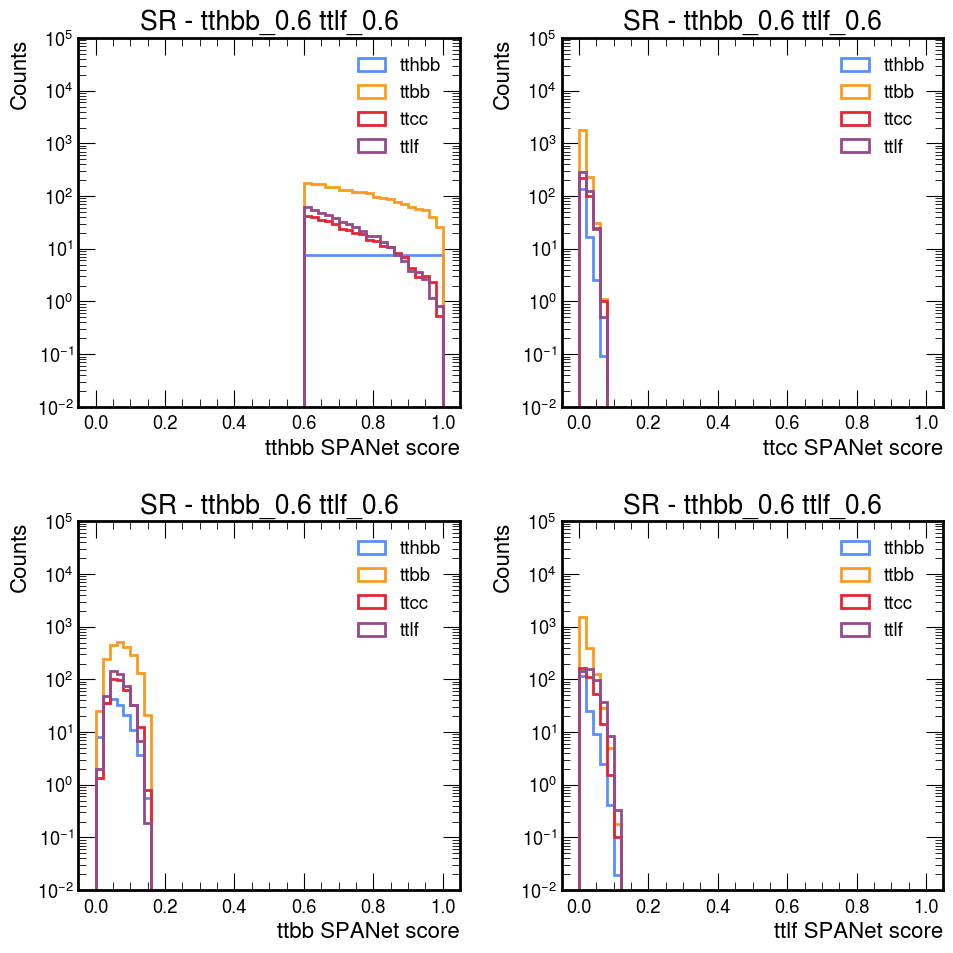

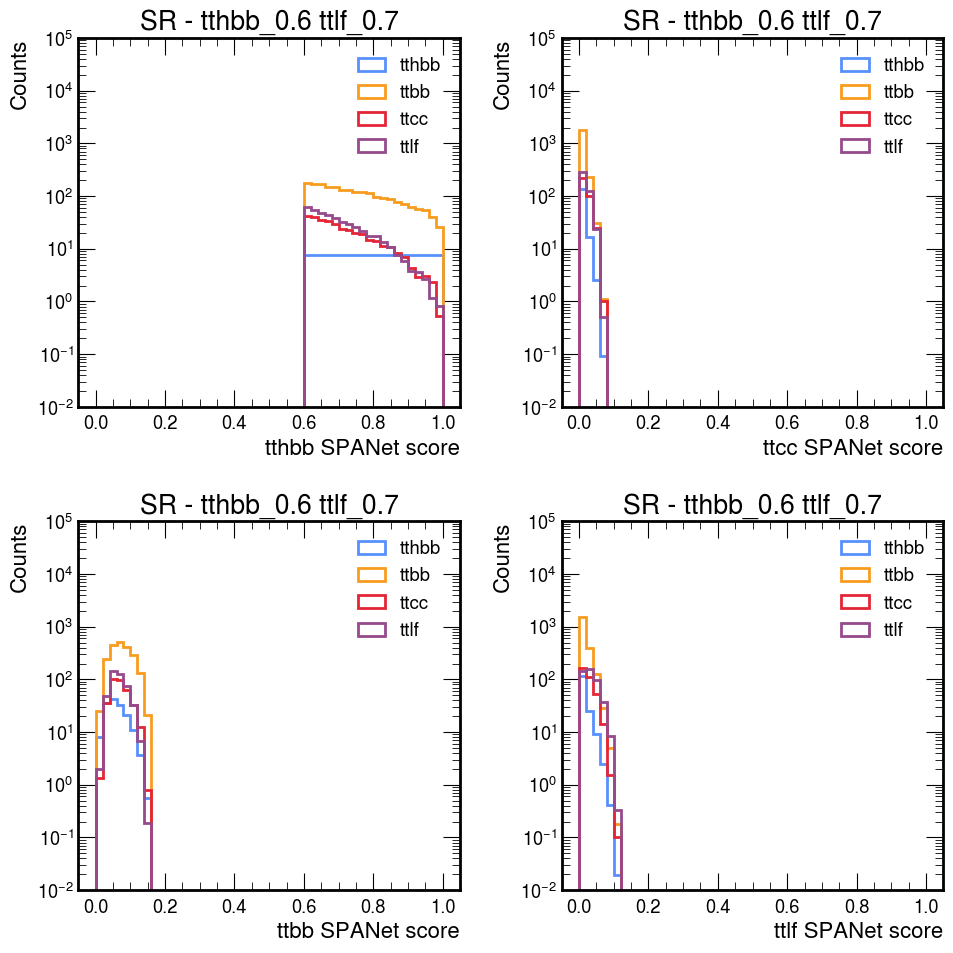

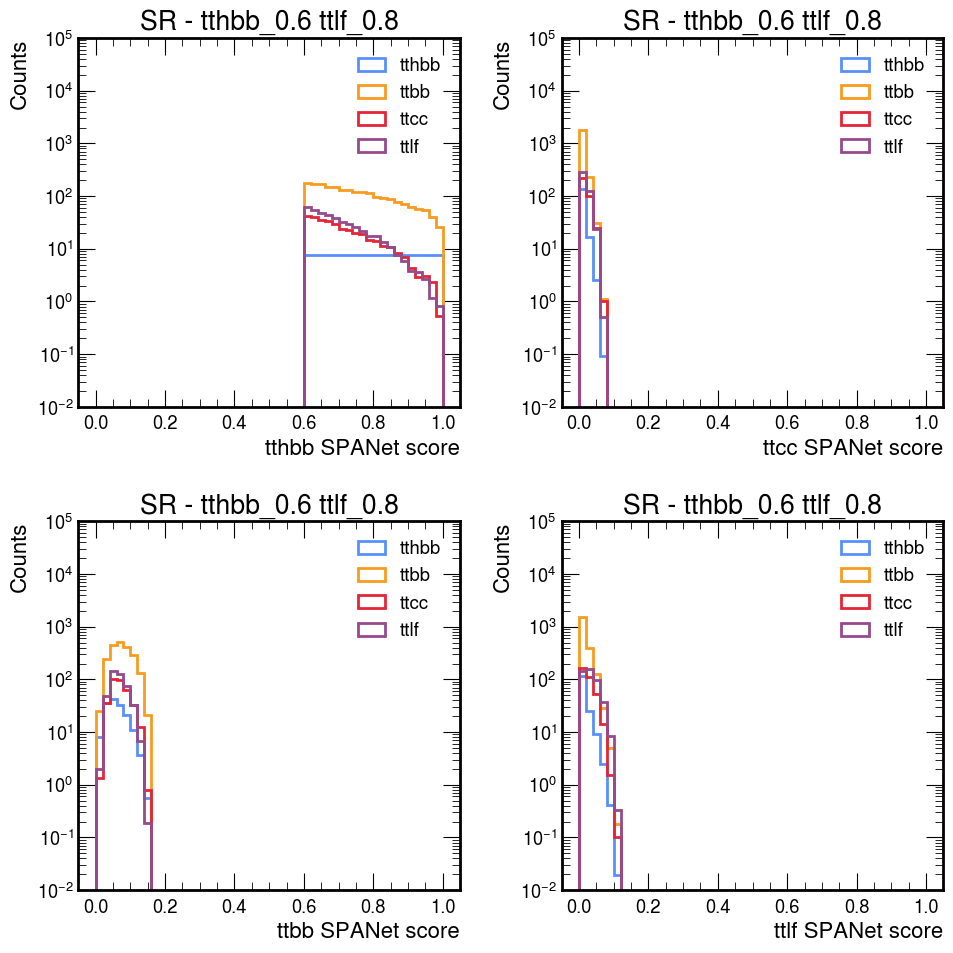

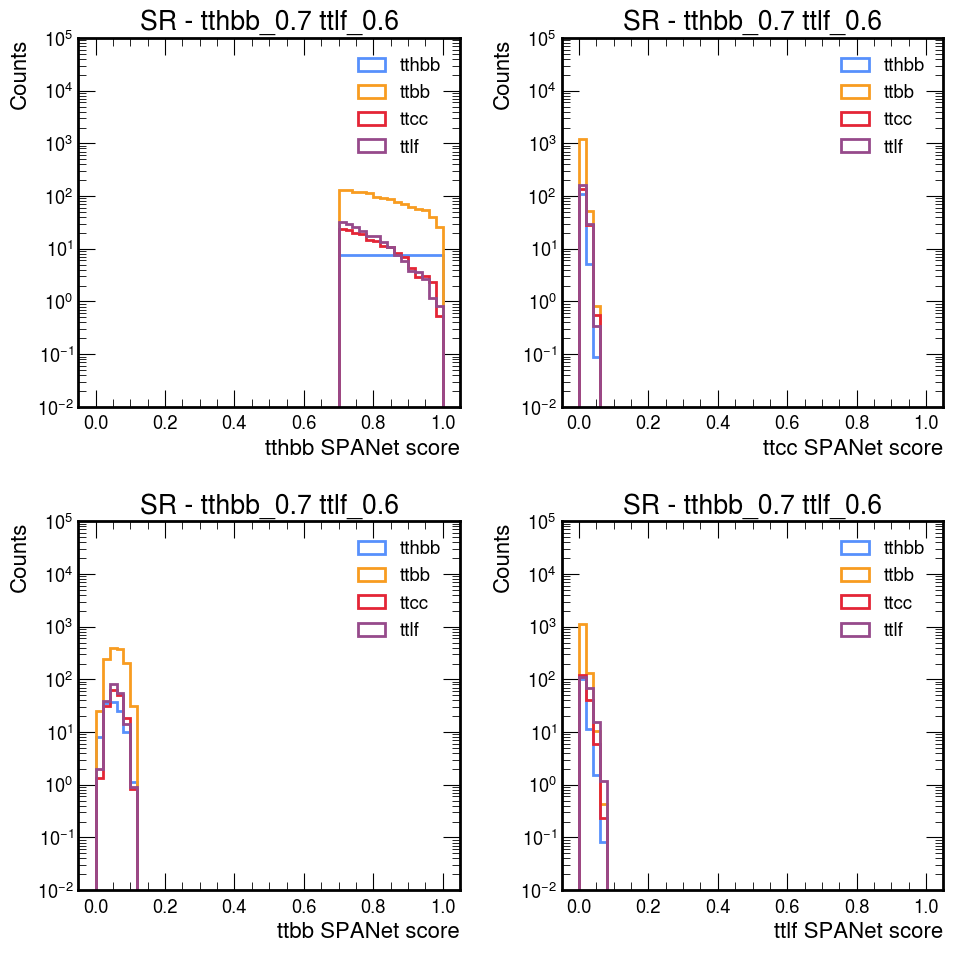

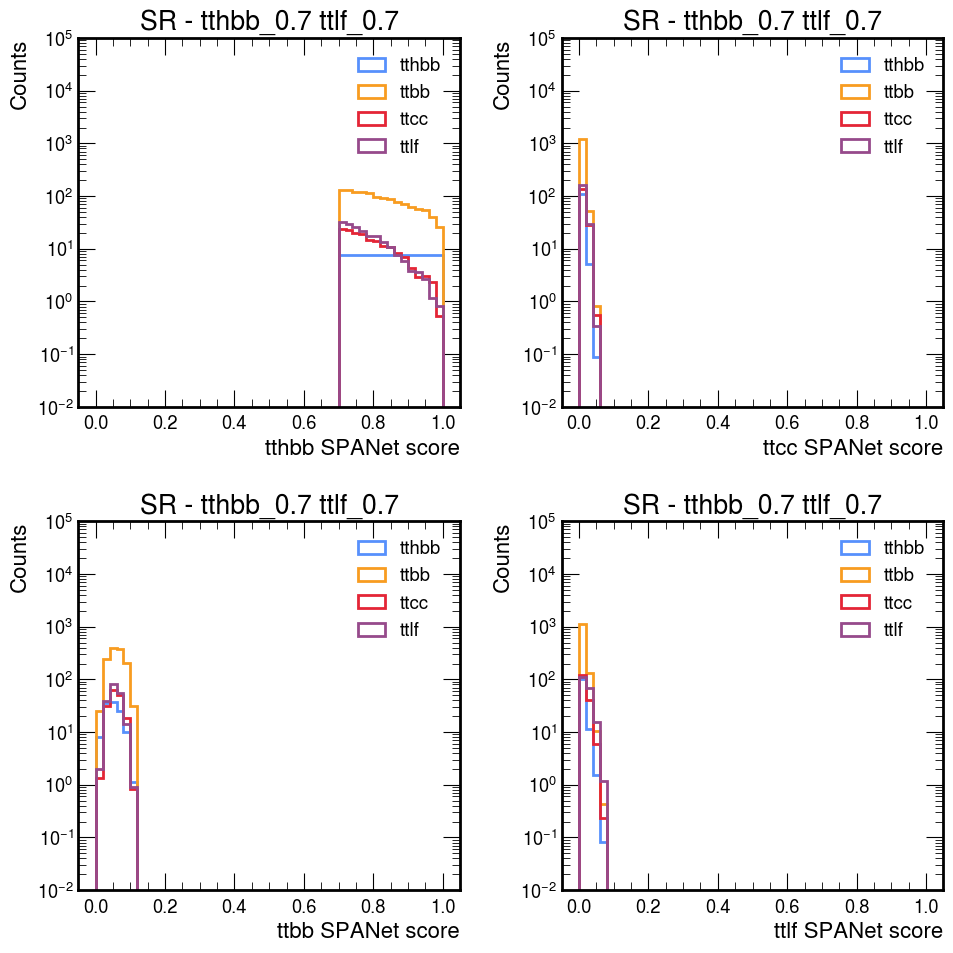

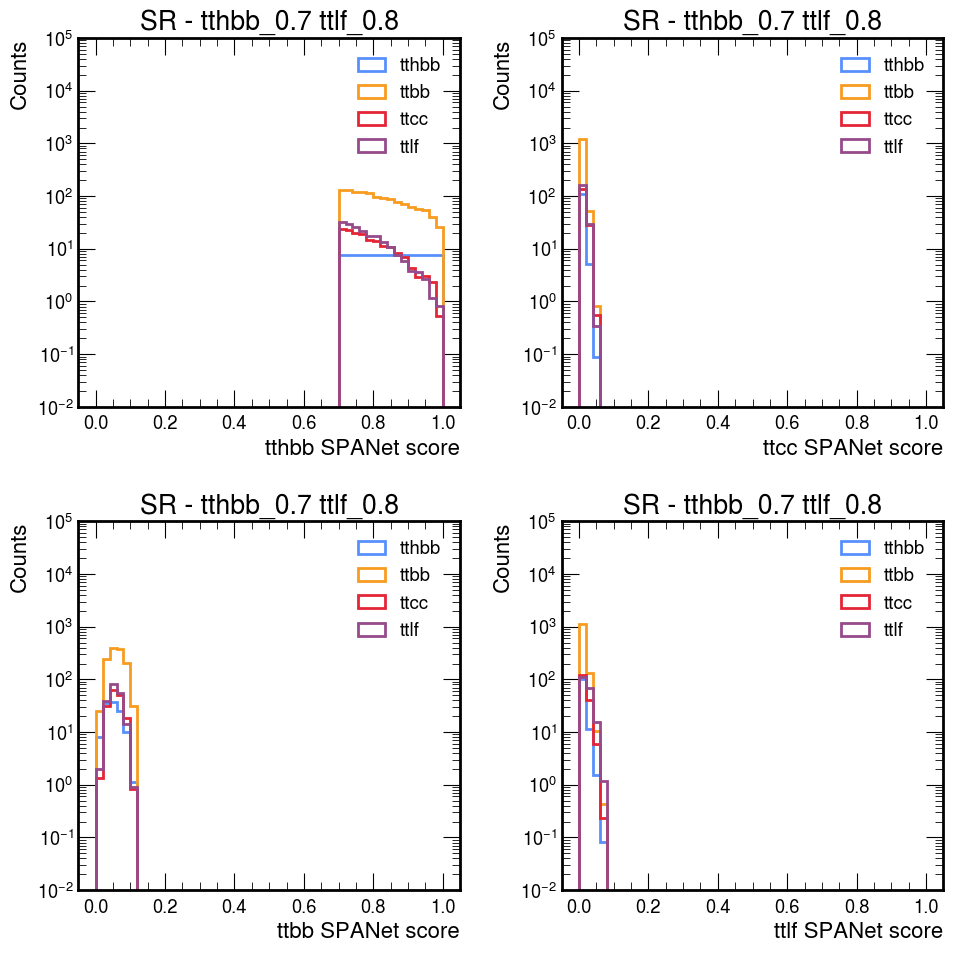

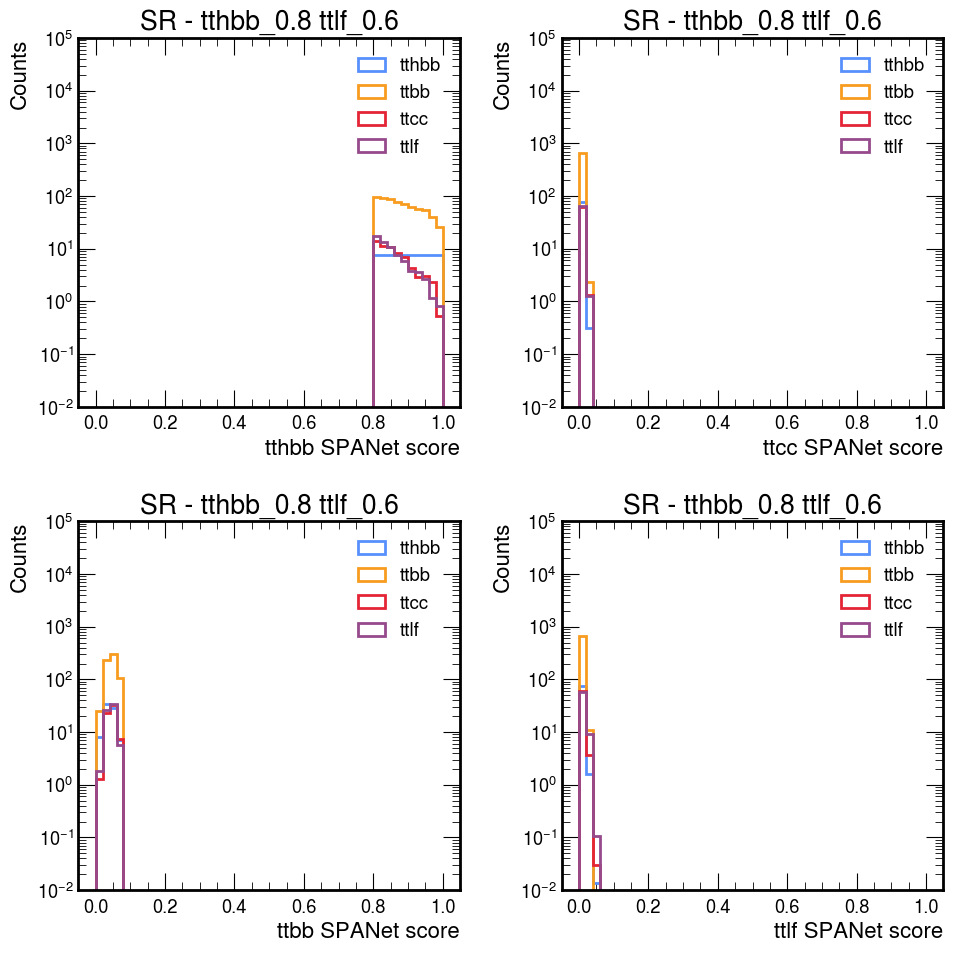

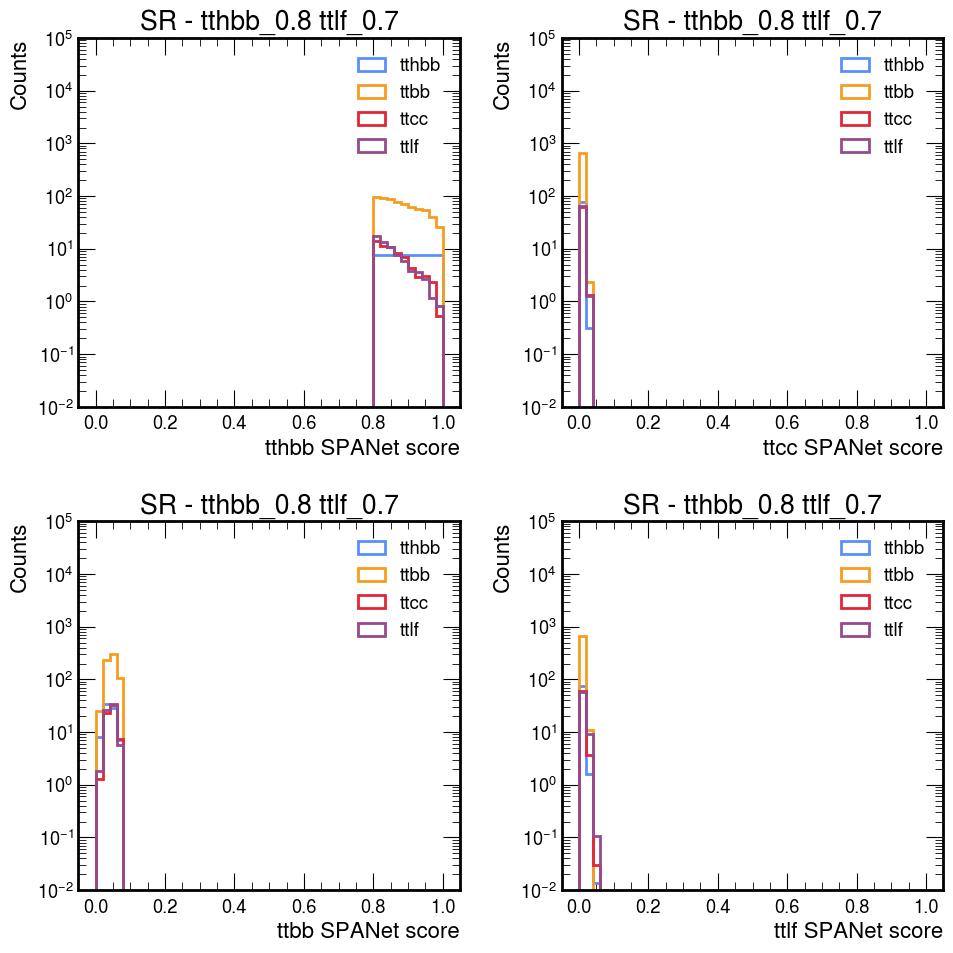

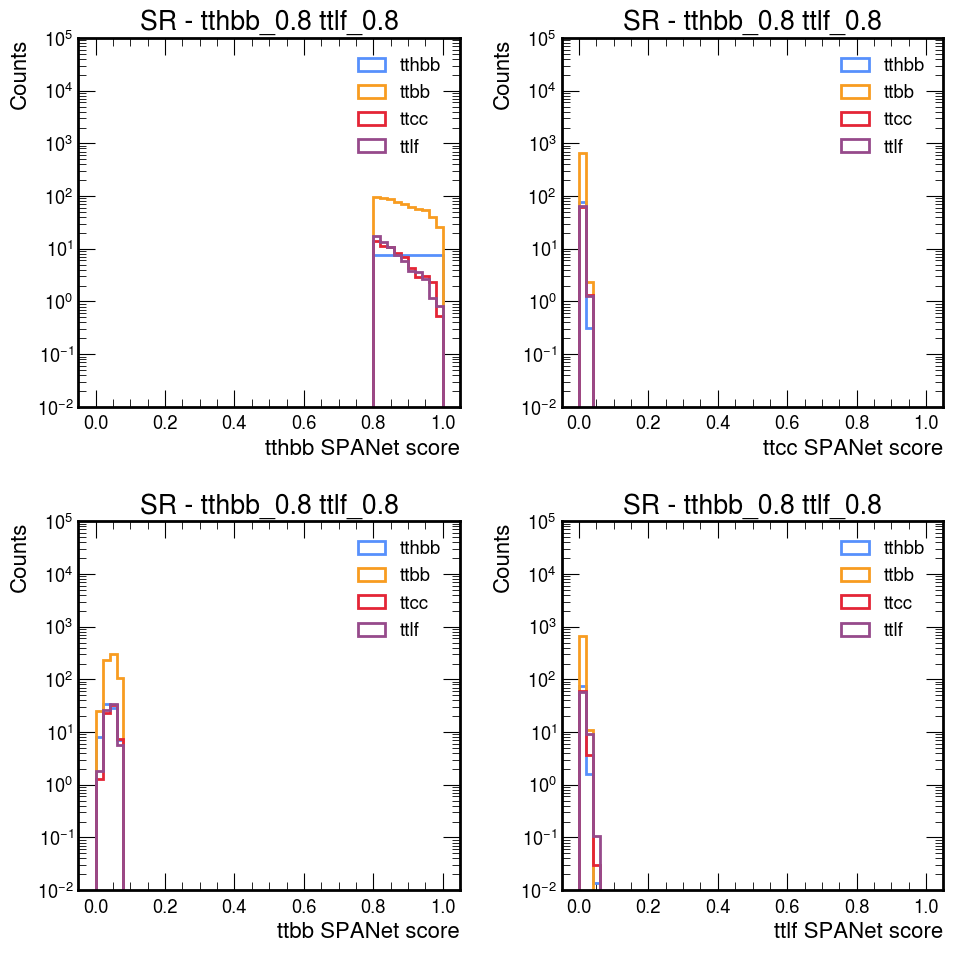

In [90]:
for tthbb_min in [0.6, 0.7, 0.8]:
    mask_tthbb = tthbb > tthbb_min
    for ttlf_max in [0.6, 0.7, 0.8]:
        mask_ttlf = ttlf < ttlf_max
        mask_CR = mask_tthbb & mask_ttlf
        plot_scores(true_labels, pred_labels_new, mask=mask_CR, weights=weights, title=f"SR - tthbb_{tthbb_min} ttlf_{ttlf_max}", ylim=(0.01, 10**5), log=True)

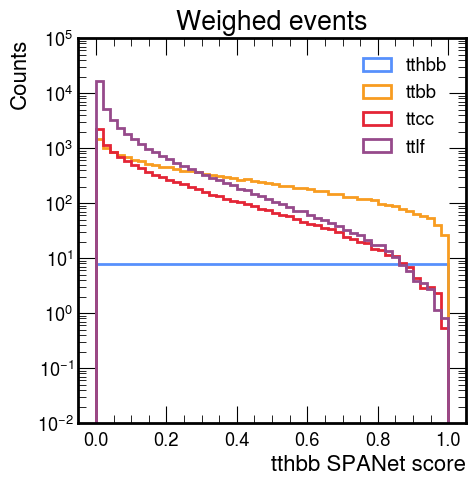

In [91]:
signal_label = "tthbb"
counts = {}

fig, ax = plt.subplots(1,1,figsize=[5,5])
for label in ["tthbb", "ttbb", "ttcc", "ttlf"]:
    mask_by_sample = true_labels[label]
    counts[label], bins, patches = plot_score(pred_labels_new[signal_label], score=signal_label, label=label, ax=ax, mask=mask_by_sample, weights=weights, title=f"Weighed events", ylim=(0.01, 10**5), log=True)

In [92]:
signal = "tthbb"
backgrounds = ["ttbb", "ttcc", "ttlf"]
S = counts[signal]
B = sum([val for key, val in counts.items() if key in backgrounds])
significance = S / np.sqrt(B)
significance

array([0.05461957, 0.091034  , 0.10977181, 0.12575184, 0.14003027,
       0.15253157, 0.16495667, 0.17907669, 0.18928485, 0.20187145,
       0.21158331, 0.22272709, 0.23649888, 0.24579636, 0.25493693,
       0.26796398, 0.28221213, 0.29025532, 0.30433578, 0.3140292 ,
       0.32965922, 0.33158217, 0.3510535 , 0.36034   , 0.37509724,
       0.38943056, 0.40492946, 0.41578577, 0.43777778, 0.44382649,
       0.46018669, 0.47979311, 0.4885423 , 0.51628356, 0.52831894,
       0.56427337, 0.5766193 , 0.60015035, 0.61279023, 0.63867079,
       0.68567834, 0.7135789 , 0.74254265, 0.7980534 , 0.84159795,
       0.91806782, 0.96451954, 1.00587205, 1.18136212, 1.48241469])

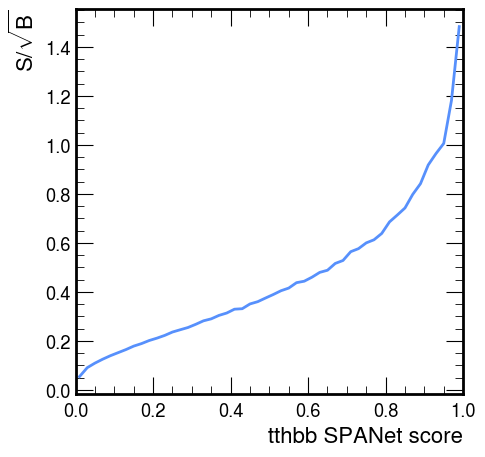

In [93]:
binwidth = 0.02
x = np.array(bins[:-1]) + 0.5*binwidth
fig, ax = plt.subplots(1,1,figsize=[5,5])
ax.plot(x, significance, linewidth=2)
ax.set_xlabel("tthbb SPANet score")
ax.set_ylabel(r"S/$\sqrt{B}$")
ax.set_xlim(0,1);

In [94]:
B

array([20055.99865723,  7222.60552979,  4967.45599365,  3785.85424805,
        3050.44891357,  2574.90267944,  2196.77148438,  1867.19546509,
        1669.92248535,  1469.83370972,  1337.0163269 ,  1206.09889221,
        1069.82858276,   991.265625  ,   919.16268921,   833.58807373,
         752.78359985,   709.70397949,   646.09603882,   606.93297577,
         551.46987915,   543.97184753,   486.36624146,   460.08699036,
         425.70714569,   394.59021759,   365.32497787,   345.73695755,
         312.40659714,   303.55486679,   282.63338089,   260.35415649,
         250.43307877,   224.58095932,   214.46412086,   188.20988846,
         179.9595108 ,   166.20337296,   159.58045387,   146.7924099 ,
         127.18425179,   117.57353592,   108.52543831,    93.94688749,
          84.51197338,    71.01208663,    64.32051444,    59.19185996,
          42.87219   ,    27.15582901])

In [95]:
w = df_test["WEIGHTS/weight"][:]
w

array([0.02987094, 0.00041705, 0.02523228, ..., 0.00037239, 0.03461251,
       0.03744688], dtype=float32)

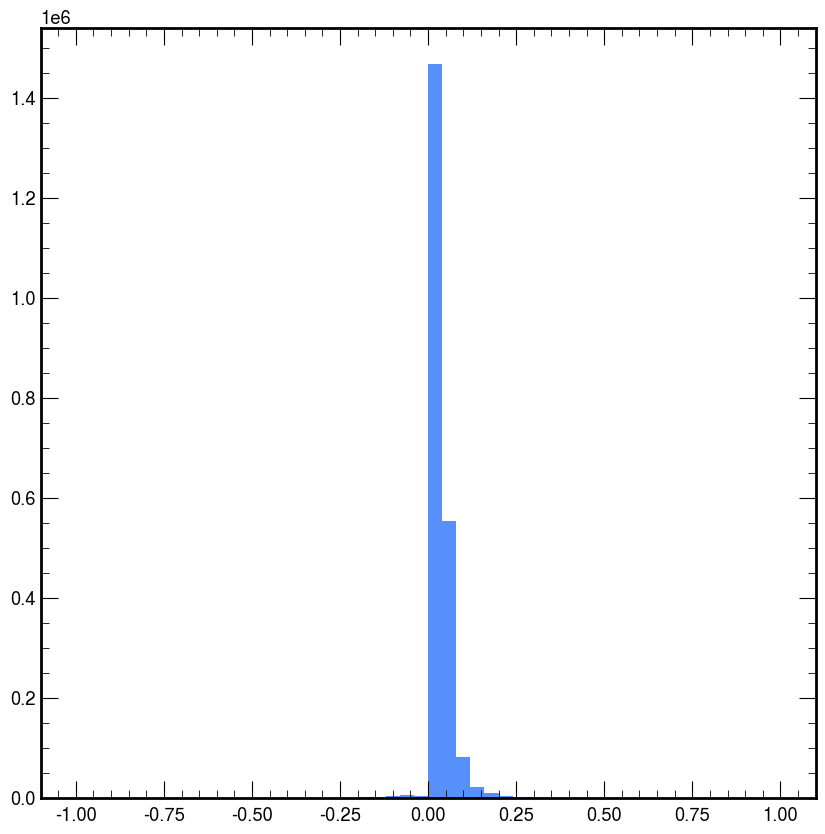

In [96]:
plt.hist(w, bins=50, range=(-1,1));

In [97]:
np.mean(w[w>0])

0.030979104